<a href="https://colab.research.google.com/github/pradlanka/Apziva/blob/main/EgwgsEeWZem4iXIs/ValueInvestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ValueInvestor




Background:


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.


Download Data:


https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/edit?usp=sharing


Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.



In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Install darts which will  be used for forecasting
!pip install darts

In [ ]:
# Mount google drive, so that we can use the data

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Read the xlsx file containing the data
# Load all sheets into a dictionary of dataframes
xls = pd.ExcelFile("/content/gdrive/My Drive/2020Q1Q2Q3Q4-2021Q1.xlsx")
sheet_dict = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}
# Function to preprocess each dataframe
def preprocess_df(df):
    # Drop the last row
    df.drop(df.tail(1).index, inplace=True)

    # Convert columns to numeric
    for col in ['Price', 'Open', 'High', 'Low', 'Change %']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convert 'Vol.' column to numeric, handling units
    df['Vol.'] = df['Vol.'].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').str.replace('-', '0')
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df.set_index('Date', inplace=True)

    # Reindex to business days
    df = df.asfreq('B')

    # Sort by date
    df.sort_index(ascending=True, inplace=True)

    # Forward fill missing values
    df.ffill(inplace=True)

    return df


# Apply preprocessing to each dataframe
sheet_dict = {sheet_name: preprocess_df(df) for sheet_name, df in sheet_dict.items()}

# Display the names of the sheets and the first few rows of each sheet
for sheet_name, df in sheet_dict.items():
    print(sheet_name)
    print(df.head(2))
    print('\n')


Russia - Sberbank Rossii PAO (S
            Price    Open    High    Low        Vol.  Change %
Date                                                          
2020-01-03  255.0  255.99  258.19  253.7  35850000.0    0.0010
2020-01-06  253.9  254.75  254.84  251.4  22350000.0   -0.0043


Turkey - Koc Holding AS (KCHOL)
            Price   Open   High    Low       Vol.  Change %
Date                                                       
2020-01-02  20.38  20.42  20.44  20.24  2530000.0    0.0030
2020-01-03  20.30  20.30  20.44  19.97  3310000.0   -0.0039


Egypt - Medinet Nasr Housing (M
            Price  Open  High   Low      Vol.  Change %
Date                                                   
2020-01-02   4.81  4.81  4.87  4.78  241600.0   -0.0021
2020-01-03   4.81  4.81  4.87  4.78  241600.0   -0.0021


Brazil - Minerva SABrazil (BEEF
            Price   Open   High    Low       Vol.  Change %
Date                                                       
2020-01-02  12.57  12.88  12.9

In [ ]:
# Function to plot the mutliple columns of the stock data
import math
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int or DataFrame) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Check if series is a DataFrame
    if isinstance(series, pd.DataFrame):
        num_columns = series.shape[1]
        fig, axes = plt.subplots(math.ceil(num_columns/3),3, figsize=(4 * num_columns, 5), sharex=True)

        if num_columns == 1:
            axes = [axes]

        for i, column in enumerate(series.columns):
            axes[i//3, i%3].plot(time[start:end], series[column][start:end], format)
            axes[i//3, i%3].set_ylabel(column)
            axes[i//3, i%3].grid(True)
            axes[i//3, i%3].set_xlabel("Time")

    else:
        # Plot a single series
        plt.figure(figsize=(10, 2))
        plt.plot(time[start:end], series[start:end], format)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.grid(True)

    # Draw the graph on screen
    plt.show()

Company:  Russia - Sberbank Rossii PAO (S


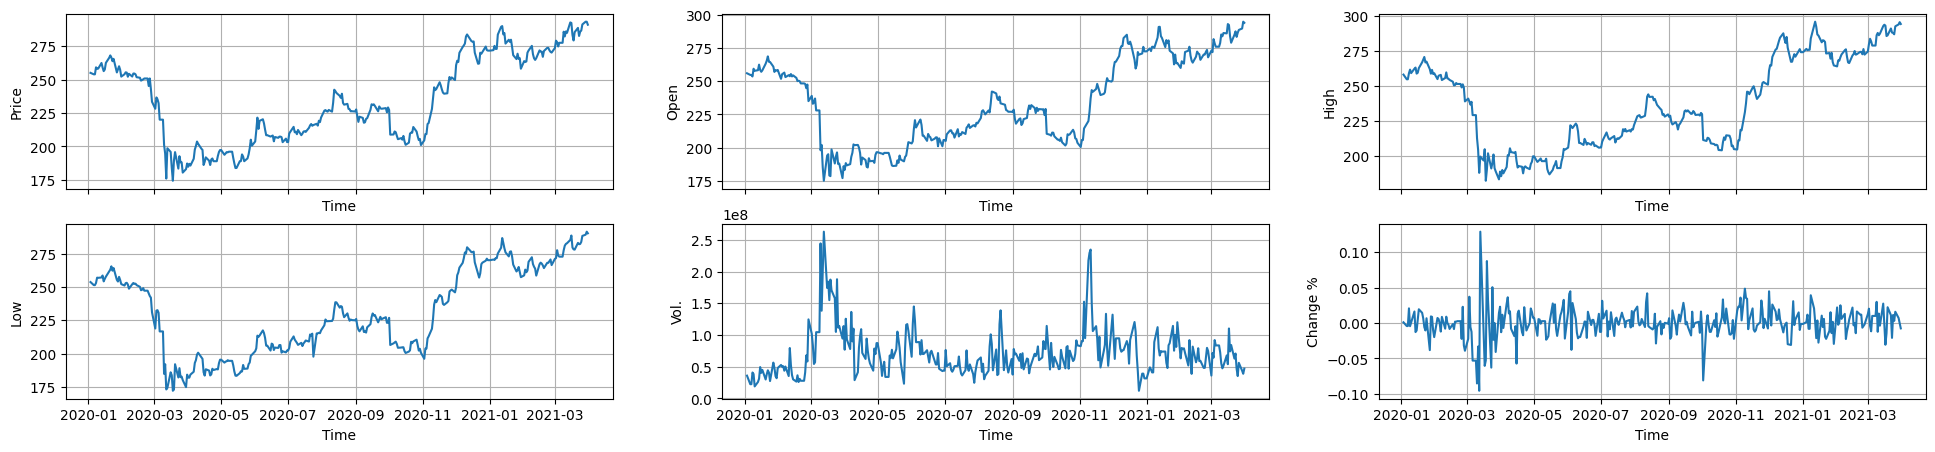

Company:  Turkey - Koc Holding AS (KCHOL)


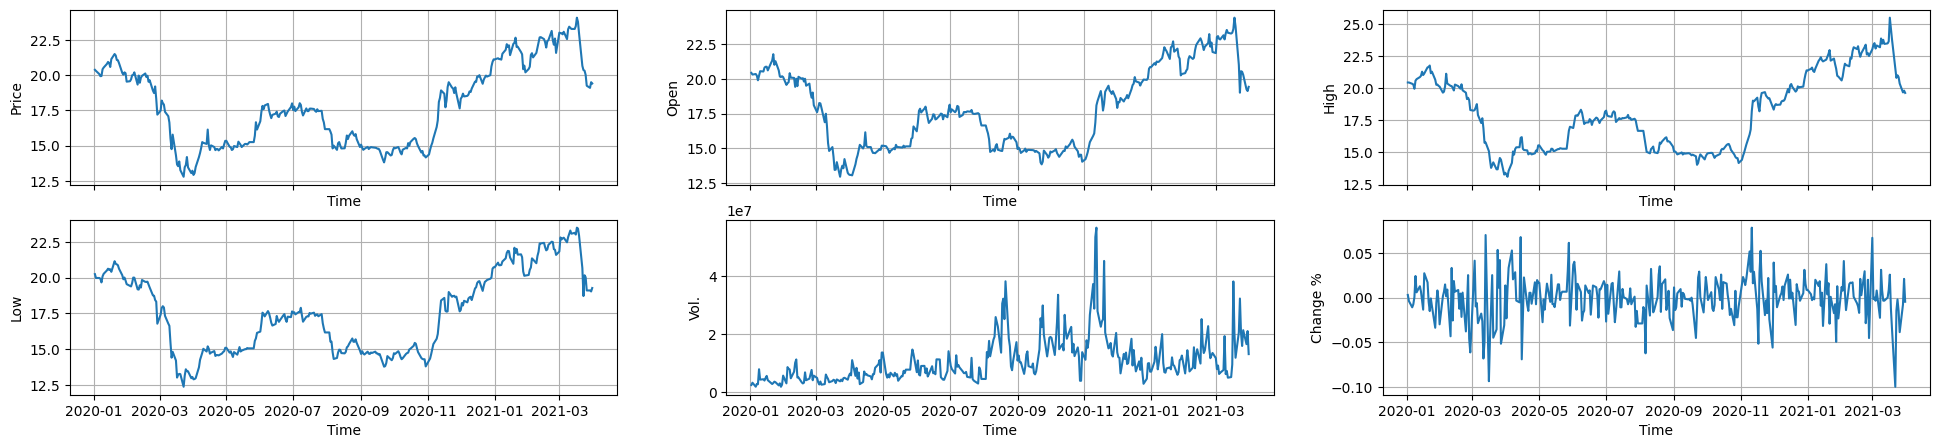

Company:  Egypt - Medinet Nasr Housing (M


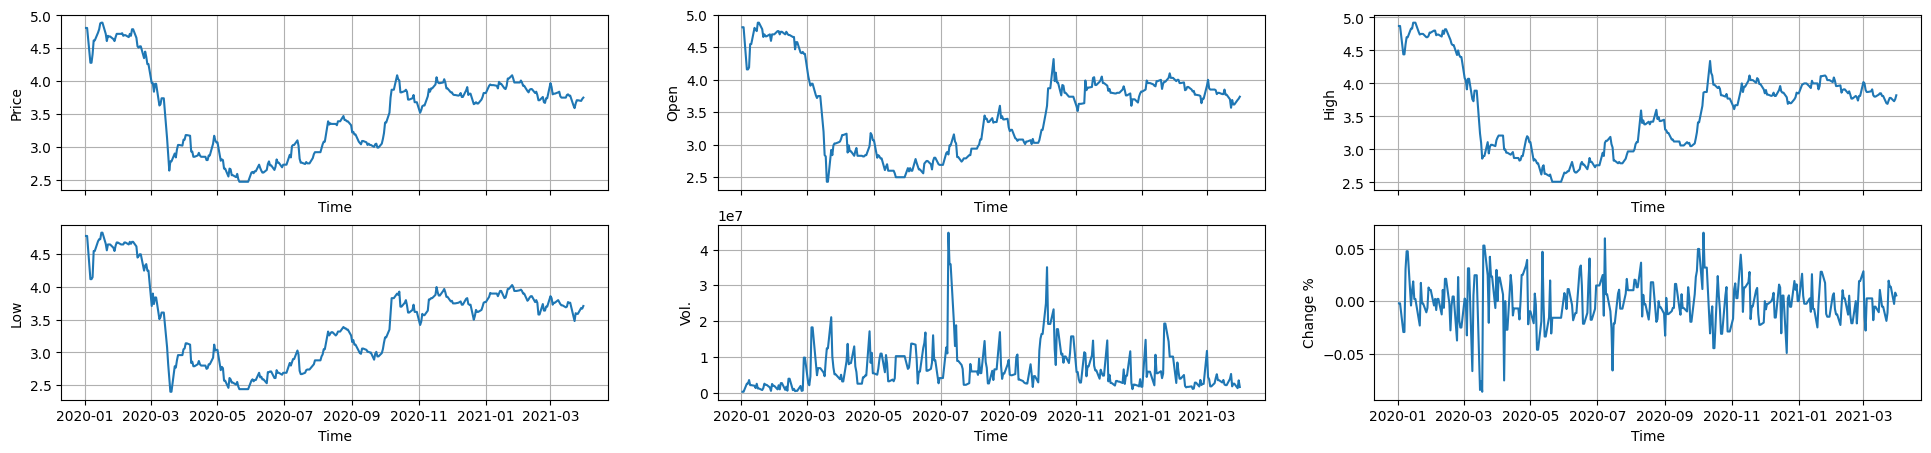

Company:  Brazil - Minerva SABrazil (BEEF


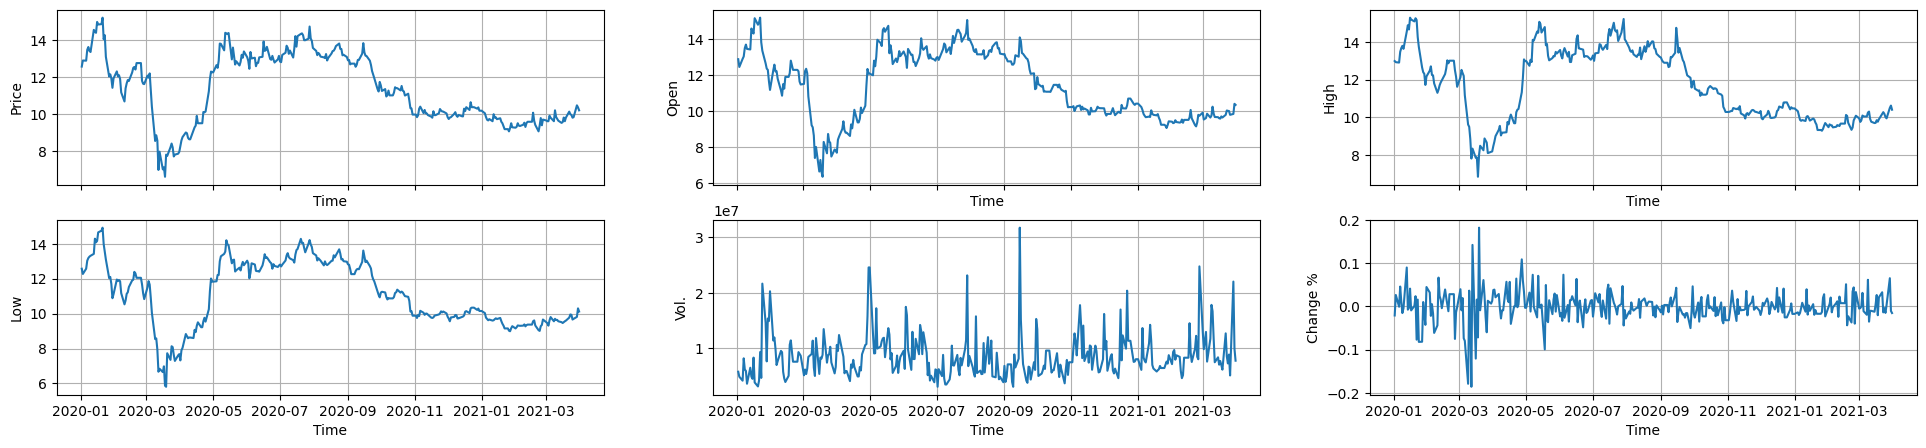

Company:  Argentina - Pampa Energia SA (P


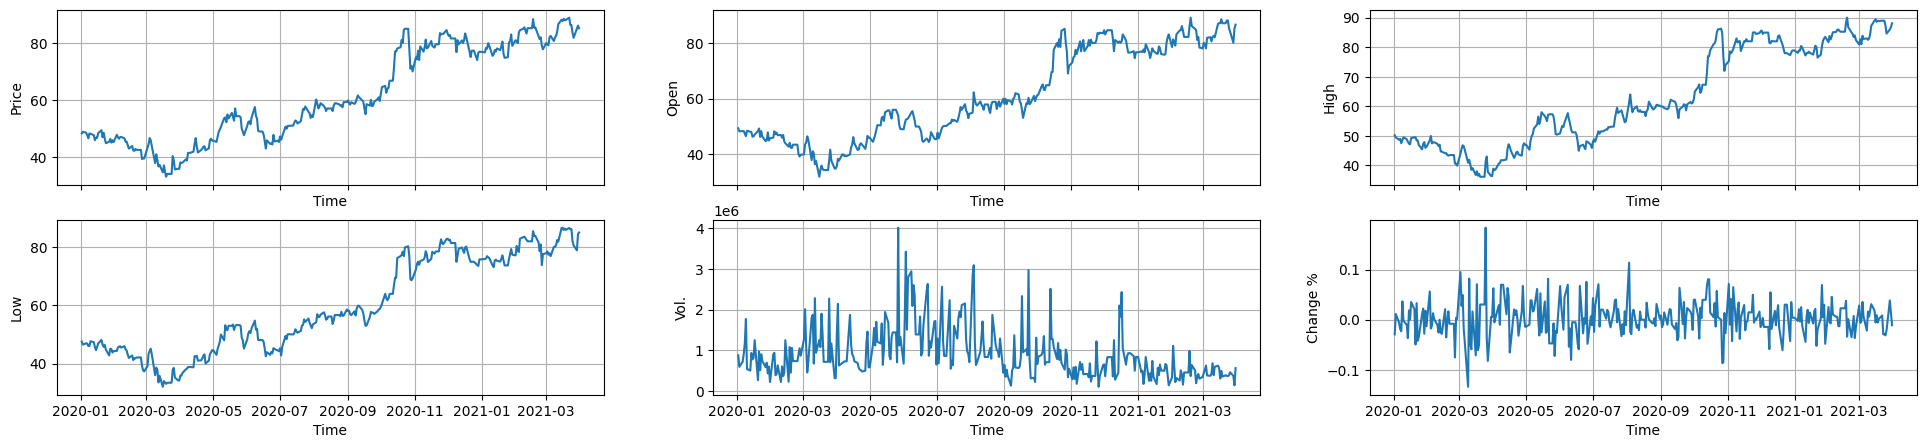

Company:  Colombia - Cementos Argos SA (C


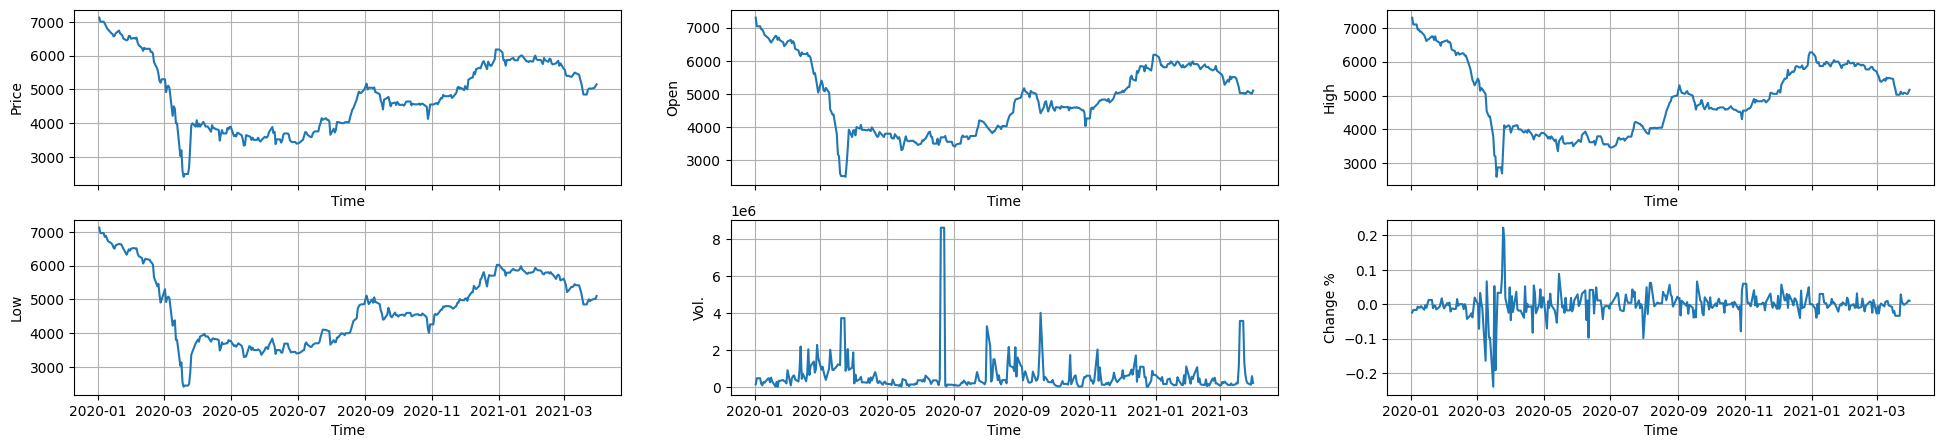

Company:  South Africa - Impala Platinum 


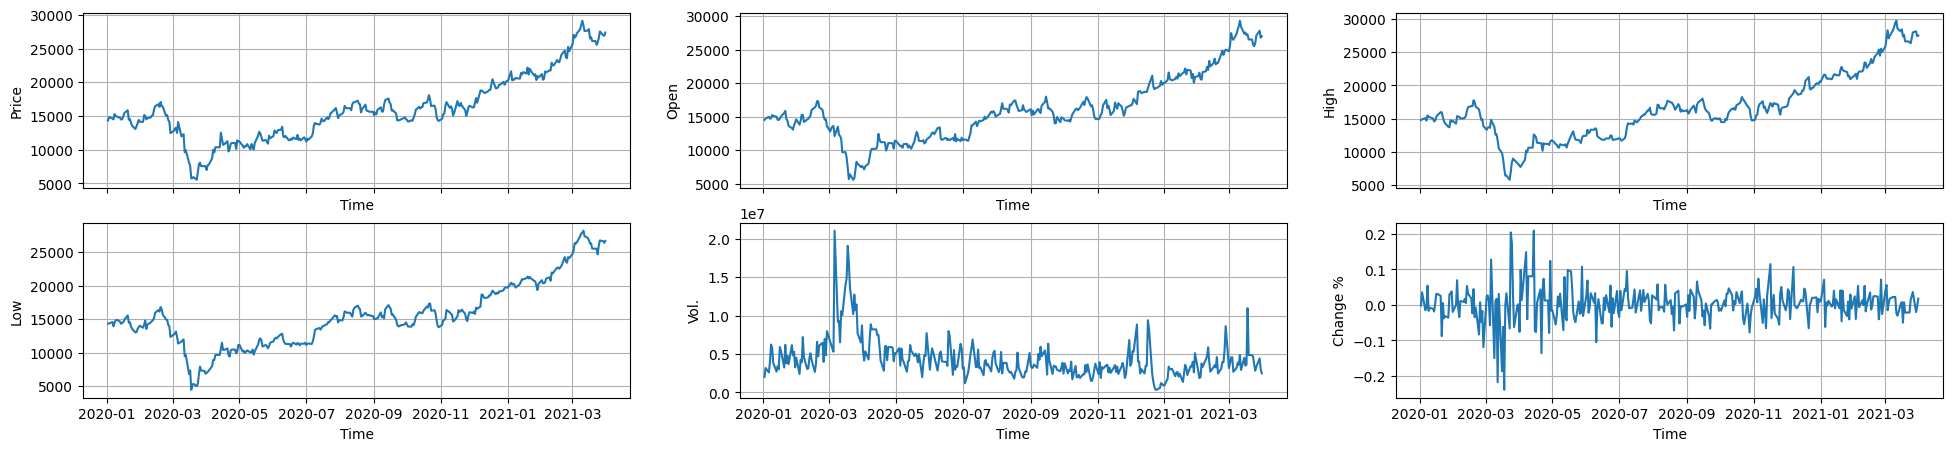

Company:  South Korea - Dongkuk Steel Mil


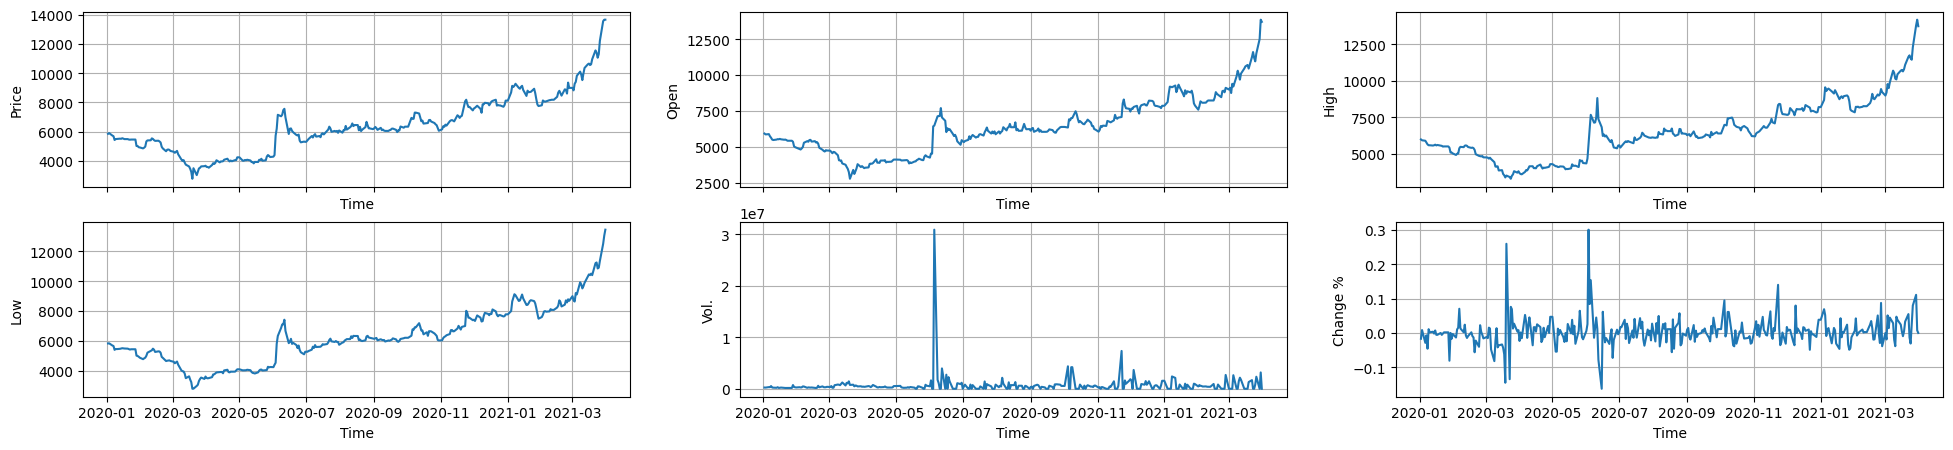

In [ ]:
# Visualziing the data for each of the 8 companies
for sheet_name, df in sheet_dict.items():
  print("Company: ", sheet_name)
  plot_series(df.index, df,  format="-", start=0, end=None)


## 1. ARIMA model.
This is the simplest model we can use. We will use the past values of the 'price' timeseries, seasonality, and trends to make predictions. We will not be using any other variables for prediction.

## **1.1 Finding the model orders of the ARIMA model from the acf, pacf plots along with the fourier analysis**

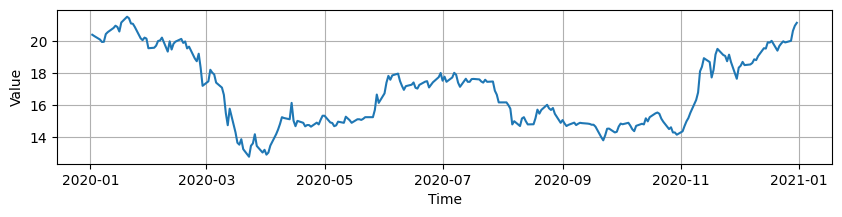

ADF Statistic: -1.508279
p-value: 0.529412
KPSS Statistic: 0.335378
p-value: 0.100000


<ipython-input-19-31096063a4b2>:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(train_data["Price"])


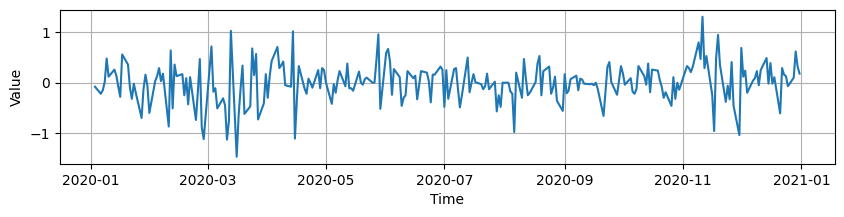

ADF Statistic: -6.353448
p-value: 0.000000
KPSS Statistic: 0.483957
p-value: 0.045280


In [ ]:
# Lets explore he data for Turkey - Koc Holding AS (KCHOL)
data = sheet_dict['Turkey - Koc Holding AS (KCHOL)']

# Split the data into training and testing sets
train_data = data[data.index < '2021-01-01']
test_data = data[data.index >= '2021-01-01']

# Ensure the data is sorted by date in ascending order for training
train_data.sort_index(ascending=True, inplace=True)
test_data.sort_index(ascending=True, inplace=True)

# Checking the time series for stationarity

# Import the adfuller and the kpss
# function
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
plot_series(train_data.index, train_data["Price"],  format="-", start=0, end=None)

# Check for stationarity using the Augmented Dickey-Fuller test
adf_test = adfuller(train_data["Price"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

# We can also do the KPSS test for stationarity
kpss_test = kpss(train_data["Price"])
print('KPSS Statistic: %f' % kpss_test[0])
print('p-value: %f' % kpss_test[1])


# Differencing the data to make it stationary

# Differencing the data
data_diff_price= train_data["Price"].diff().dropna()

# Plot the differenced data
plot_series(data_diff_price.index, data_diff_price,  format="-", start=0, end=None)

# Check for stationarity
adf_test_diff = adfuller(data_diff_price)
print('ADF Statistic: %f' % adf_test_diff[0])
print('p-value: %f' % adf_test_diff[1])

kpss_test_diff = kpss(data_diff_price)
print('KPSS Statistic: %f' % kpss_test_diff[0])
print('p-value: %f' % kpss_test_diff[1])


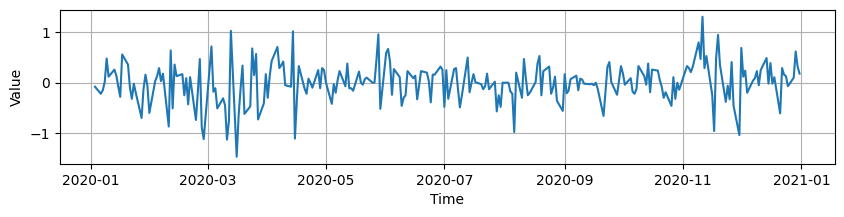

ADF Statistic: -6.353448
p-value: 0.000000
KPSS Statistic: 0.483957
p-value: 0.045280


In [ ]:

# Differencing the data to make it stationary

# Differencing the data
data_diff_price= train_data["Price"].diff().dropna()

# Plot the differenced data
plot_series(data_diff_price.index, data_diff_price,  format="-", start=0, end=None)

# Check for stationarity
adf_test_diff = adfuller(data_diff_price)
print('ADF Statistic: %f' % adf_test_diff[0])
print('p-value: %f' % adf_test_diff[1])

kpss_test_diff = kpss(data_diff_price)
print('KPSS Statistic: %f' % kpss_test_diff[0])
print('p-value: %f' % kpss_test_diff[1])



After differencing the data the time series does appear to be stationary. So the d may be 1.
If the p-value is less than a chosen significance level (< 0.05), we reject the null hypothesis and conclude that the series is non-stationary, else,we do not reject the null hypothesis and conclude that the series is stationary.

Here since p-value of the orignial data is less than p<0.05, then the time series is non-stationary. However for differenced data the time series is indeed stationary.
Let us plot the autocorrelation plots to help determine the p (lags) to consider for the ARIMA model

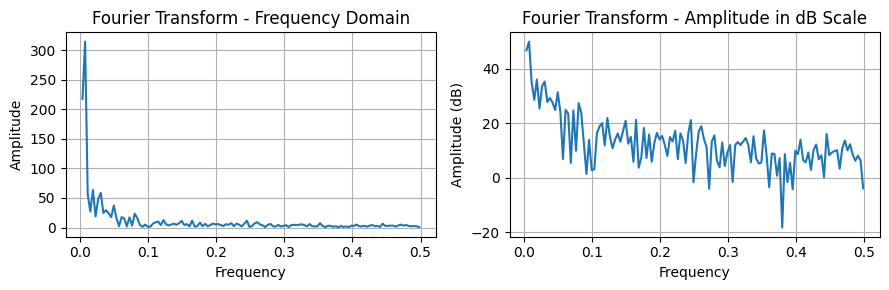

In [ ]:
# Let us look for any seasonality in the data

# Perform FFT
fft_values = np.fft.fft(train_data['Price'])
fft_freq = np.fft.fftfreq(len(fft_values))
# Compute amplitude in dB scale
amplitude_db = 20 * np.log10(np.abs(fft_values))

# We are only interested in the positive frequencies
positive_frequencies = fft_freq > 0
# Plot the FFT results
fig, axs = plt.subplots(1, 2,figsize=(9, 3))

# Plot amplitude
axs[0].plot(fft_freq[positive_frequencies], np.abs(fft_values)[positive_frequencies])
axs[0].set_title("Fourier Transform - Frequency Domain")
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

# Plot amplitude in dB scale
axs[1].plot(fft_freq[positive_frequencies], amplitude_db[positive_frequencies])
axs[1].set_title("Fourier Transform - Amplitude in dB Scale")
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("Amplitude (dB)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Since, there are no spikes in the frequency, there are no seasonal patterns, hence we can use an ARIMA model, as comapred to a SARIMA model, which we can use when our data has seasonality.

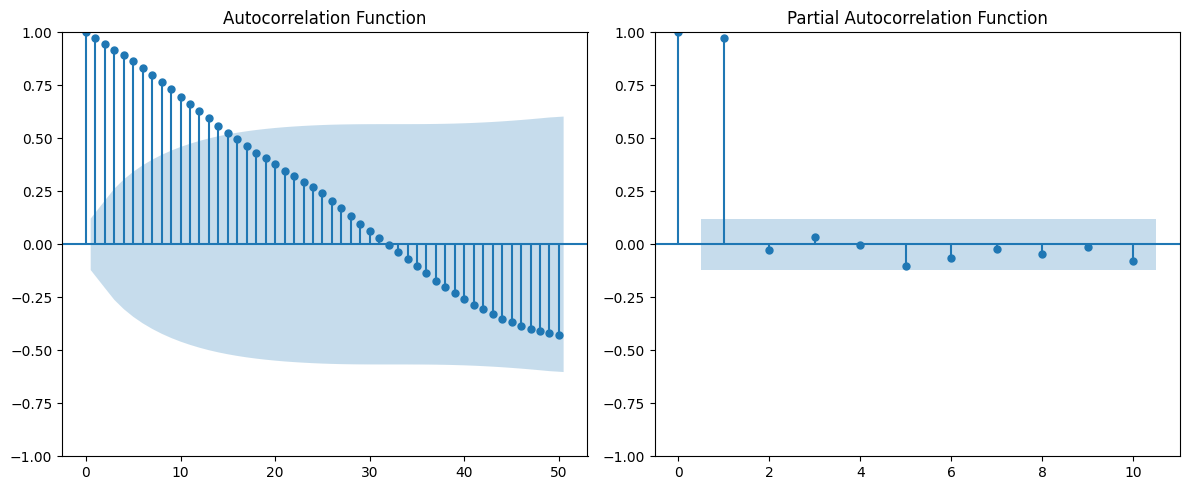

In [ ]:
# Determining the order of the ARIMA model using the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF in the same plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
plot_acf(train_data["Price"], ax=axes[0], lags=50)
axes[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(train_data["Price"], ax=axes[1], lags=10)
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

From the autocorrelation plot, we can see that the autocorrelation gradually decreases and does not cut off abruptly. However, the partial autocorrelation plot shows a sharp cut-off after a few lags. This suggests that the data may be an AR(1) process.

We can use ARIMA (1,1,0) or ARIMA (1,1,1) to model our time series. We can will plot the model using ARIMA (1,1,0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

def ts_forecast_arima(data, target_col='Price', forecast_month='December', forecast_year=2020):

    # Ensure the datetime index has a frequency
    if data.index.freq is None:
        data.index.freq = pd.infer_freq(data.index)
    if data.index.freq is None:  # If still None, set to business day frequency
        data.index.freq = 'B'

    # Determine the business days in the forecast month
    forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
    forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
    forecast_steps = len(forecast_index)

    # Split data into training and validation sets (last business days of November for December forecasting)
    train_data = data[data.index < forecast_start_date]
    val_data = data[(data.index >= forecast_start_date) & (data.index <= forecast_end_date)]

    # Fit ARIMA(1,1,0)
    model_order = (1, 1, 0)
    arima_model_110 = ARIMA(train_data[target_col], order=model_order)
    arima_results_110 = arima_model_110.fit()
    print('ARIMA(1,1,0) Summary:')
    print(arima_results_110.summary())

    # Plot diagnostics
    arima_results_110.plot_diagnostics(figsize=(8, 6))
    plt.tight_layout()
    plt.show()

    # Initialize a DataFrame to store the forecasts
    forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

    # Perform rolling forecast
    for i in range(forecast_steps):
        # Forecast the next step
        forecast = arima_results_110.get_forecast(steps=1)
        forecast_df.iloc[i] = forecast.predicted_mean.values

        # Update the model with the new data point
        train_data = pd.concat([train_data, val_data.iloc[[i]]])
        arima_model_110 = ARIMA(train_data[target_col], order=model_order)
        arima_results_110 = arima_model_110.fit(method_kwargs={"maxiter": 200, "disp": 0})

    # Ensure forecast_df has a datetime index
    forecast_df.index = forecast_index

    # Evaluate ARIMA model
    mse_arima = mean_squared_error(val_data[target_col], forecast_df['Forecast'])
    print(f'Mean Squared Error for ARIMA: {mse_arima}')

    # Compute the Bollinger Bands
    rolling_mean = forecast_df['Forecast'].rolling(window=2).mean()
    rolling_std = forecast_df['Forecast'].rolling(window=2).std()
    forecast_df['Upper Band'] = rolling_mean + (rolling_std * 2)
    forecast_df['Lower Band'] = rolling_mean - (rolling_std * 2)

    # Plot the actual vs forecasted values with Bollinger Bands
    plt.figure(figsize=(8, 3))
    plt.plot(data.index, data[target_col], label='Actual')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
    plt.fill_between(forecast_df.index, forecast_df['Upper Band'], forecast_df['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
    plt.legend(loc='best')
    plt.title('Rolling Forecast vs Actual with Bollinger Bands')
    plt.show()

ARIMA(1,1,0) Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  238
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -118.189
Date:                Wed, 10 Jul 2024   AIC                            240.378
Time:                        15:19:18   BIC                            247.314
Sample:                    01-02-2020   HQIC                           243.173
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0674      0.047      1.437      0.151      -0.025       0.159
sigma2         0.1587      0.011     14.057      0.000       0.137       0.181
Ljung-Box (L1) (Q):           

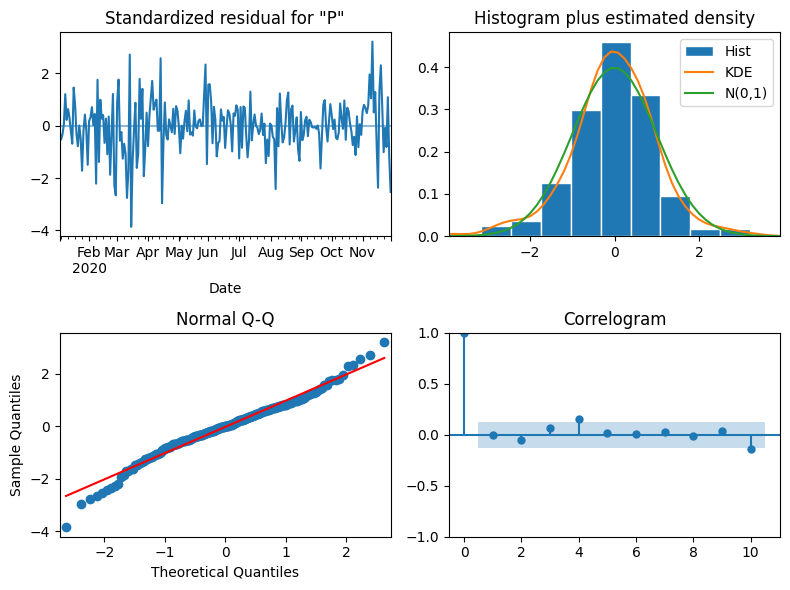

Mean Squared Error for ARIMA: 0.0972210251128867


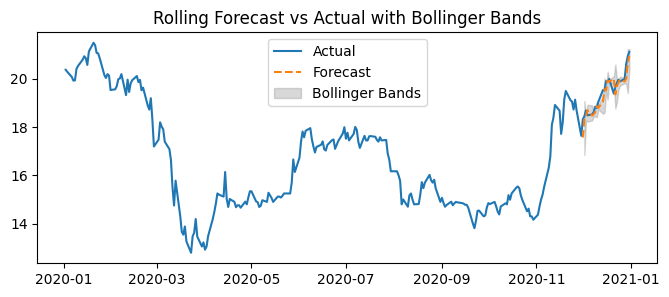

In [ ]:
ts_forecast_arima(train_data)

## **1.2 Using AutoARIMA to automatically find the optimal p,d,q for the ARIMA model**

In [ ]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def ts_forecast_arima_auto(data, target_col='Price',  forecast_month='December', forecast_year=2020):

    # Ensure the datetime index has a frequency
    if data.index.freq is None:
        data.index.freq = pd.infer_freq(data.index)
    if data.index.freq is None:  # If still None, set to business day frequency
        data.index.freq = 'B'

    # Determine the business days in the forecast month
    forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
    forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
    forecast_steps = len(forecast_index)

    # Split data into training and validation sets (last business days of November for December forecasting)
    train_data = data[data.index < forecast_start_date]
    val_data = data[(data.index >= forecast_start_date) & (data.index <= forecast_end_date)]


    # Optimize ARIMA parameters
    auto_arima_model = auto_arima(train_data[target_col],
                                  start_p=0, start_q=0,
                                  max_p=10, max_q=10,
                                  seasonal=False,
                                  trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=False)

    # Print the optimal order
    print(f'Optimal order: {auto_arima_model.order}')

    # Initialize a DataFrame to store the forecasts
    forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

    # Perform rolling forecast
    for i in range(forecast_steps):
        # Fit the model on the entire training dataset up to the current point
        model = ARIMA(train_data[target_col],
                      order=auto_arima_model.order)
        results = model.fit(method_kwargs={"maxiter": 200, "disp": 0})

        # Forecast the next step
        forecast = results.forecast(steps=1)
        forecast_df.iloc[i] = forecast.values

        # Append the forecasted value to the training data
        new_train_data = pd.concat([train_data, val_data.iloc[[i]]])
        # Update training data
        train_data = new_train_data

    # Ensure forecast_df has a datetime index
    forecast_df.index = forecast_index

    # Evaluate ARIMA model
    mse_arima = mean_squared_error(val_data[target_col], forecast_df['Forecast'])
    print(f'Mean Squared Error for ARIMA: {mse_arima}')

    # Compute the Bollinger Bands
    rolling_mean = forecast_df['Forecast'].rolling(window=2).mean()
    rolling_std = forecast_df['Forecast'].rolling(window=2).std()
    forecast_df['Upper Band'] = rolling_mean + (rolling_std * 2)
    forecast_df['Lower Band'] = rolling_mean - (rolling_std * 2)

    # Plot the actual vs forecasted values with Bollinger Bands
    plt.figure(figsize=(8, 3))
    plt.plot(data.index, data[target_col], label='Actual')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
    plt.fill_between(forecast_df.index, forecast_df['Upper Band'], forecast_df['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
    plt.legend(loc='best')
    plt.title('Rolling Forecast vs Actual with Bollinger Bands')
    plt.show()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.232, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.090, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=243.712, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=245.036, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=239.944, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=241.675, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=242.194, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=245.069, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=242.896, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=241.368, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=243.764, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=245.581, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=246.648, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept

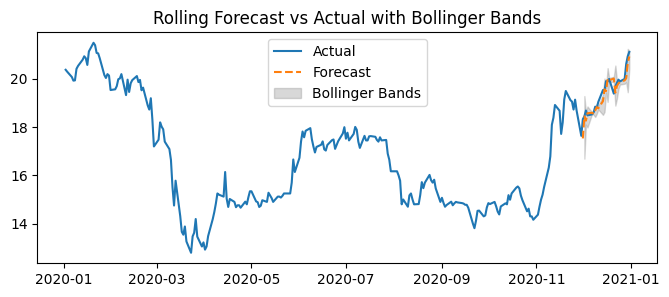

In [ ]:
ts_forecast_arima_auto(train_data)

### **1.3 Using Exogenous variables such as the previous values of the ARIMA model such as the Open, high, low, vol and change cols of the previous days and doing it for all companies.**

In [155]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def create_lagged_features(data, target_col, lags=3):
    lagged_data = data.copy()
    for column in data.columns:
        if column != target_col:
            for lag in range(1, lags + 1):
                lagged_data[f'{column}_lag{lag}'] = data[column].shift(lag)
    lagged_data.dropna(inplace=True)  # Drop rows with NaN values caused by lagging
    return lagged_data

def ts_forecast_arimax(sheet_dict, target_col='Price', forecast_month='December', forecast_year=2020, lags=3):
    forecast_results = {}
    models = {}
    performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2 Score'])

    for sheet_name, df in sheet_dict.items():
        print(f"Processing sheet: {sheet_name}")

        # Ensure the datetime index has a frequency
        if df.index.freq is None:
            df.index.freq = pd.infer_freq(df.index)
        if df.index.freq is None:  # If still None, set to business day frequency
            df.index.freq = 'B'

        # Create lagged features for exogenous variables
        df = create_lagged_features(df, target_col, lags)

        # Determine the business days in the forecast month
        forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
        forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
        forecast_steps = len(forecast_index)

        # Split data into training and validation sets for forecasting
        train_data = df.loc[df.index < forecast_start_date]
        val_data = df.loc[(df.index >= forecast_start_date) & (df.index <= forecast_end_date)]

        # Prepare lagged exogenous variables
        exog_cols = [col for col in train_data.columns if col != target_col]
        train_exog = train_data[exog_cols]
        val_exog = val_data[exog_cols]

        # Optimize ARIMA parameters with lagged exogenous variables
        auto_arima_model = auto_arima(train_data[target_col],
                                      exogenous=train_exog,
                                      start_p=0, start_q=0,
                                      max_p=10, max_q=10,
                                      seasonal=False,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=False)

        # Print the optimal order
        print(f'Optimal order: {auto_arima_model.order}')

        # Initialize a DataFrame to store the forecasts
        forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

        # Perform rolling forecast
        for i in range(forecast_steps):
            # Fit the model on the entire training dataset up to the current point
            model = ARIMA(train_data[target_col], order=auto_arima_model.order, exog=train_exog)
            results = model.fit(method_kwargs={"maxiter": 5000, "disp": 0})

            # Forecast the next step using past values of the exogenous variables
            forecast = results.forecast(steps=1, exog=val_exog.iloc[[i]])
            forecast_df.iloc[i] = forecast.values

            # Append the forecasted value to the training data
            new_train_data = pd.concat([train_data, val_data.iloc[[i]]])
            new_train_data.loc[val_data.index[i], target_col] = forecast.values[0]  # Use the forecasted value for the target column
            new_train_exog = pd.concat([train_exog, val_exog.iloc[[i]]])

            # Update training data
            train_data = new_train_data
            train_exog = new_train_exog

        # Store the trained model
        models[sheet_name] = model

        # Ensure forecast_df has a datetime index
        forecast_df.index = forecast_index

        # Evaluate ARIMA model
        mse_arima = mean_squared_error(val_data[target_col], forecast_df['Forecast'])
        mae_arima = mean_absolute_error(val_data[target_col], forecast_df['Forecast'])
        r2_arima = r2_score(val_data[target_col], forecast_df['Forecast'])
        mape_arima = np.mean(np.abs((val_data[target_col] - forecast_df['Forecast']) / val_data[target_col])) * 100
        smape_arima = np.mean(2 * np.abs(val_data[target_col] - forecast_df['Forecast']) / (np.abs(val_data[target_col]) + np.abs(forecast_df['Forecast']))) * 100

        # Store performance metrics
        performance_metrics.loc[sheet_name, 'MAE'] = mae_arima
        performance_metrics.loc[sheet_name, 'RMSE'] = np.sqrt(mse_arima)
        performance_metrics.loc[sheet_name, 'MAPE'] = mape_arima
        performance_metrics.loc[sheet_name, 'SMAPE'] = smape_arima
        performance_metrics.loc[sheet_name, 'R2 Score'] = r2_arima

        print(f'Mean Squared Error for {sheet_name} (ARIMAX): {mse_arima}')
        print(f'Mean Absolute Error for {sheet_name} (ARIMAX): {mae_arima}')
        print(f'R2 Score for {sheet_name} (ARIMAX): {r2_arima}')
        print(f'MAPE for {sheet_name} (ARIMAX): {mape_arima}')
        print(f'SMAPE for {sheet_name} (ARIMAX): {smape_arima}')

        # Compute the Bollinger Bands
        rolling_mean = forecast_df['Forecast'].rolling(window=2).mean()
        rolling_std = forecast_df['Forecast'].rolling(window=2).std()
        forecast_df['Upper Band'] = rolling_mean + (rolling_std * 2)
        forecast_df['Lower Band'] = rolling_mean - (rolling_std * 2)

        # Plot the actual vs forecasted values with Bollinger Bands
        plt.figure(figsize=(8, 3))
        plt.plot(train_data.index, train_data[target_col], label='Actual')
        plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
        plt.fill_between(forecast_df.index, forecast_df['Upper Band'], forecast_df['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
        plt.legend(loc='best')
        plt.title(f'Rolling Forecast vs Actual with Bollinger Bands for {sheet_name}')
        plt.show()

        forecast_results[sheet_name] = forecast_df

    return forecast_results, performance_metrics, models

Processing sheet: Russia - Sberbank Rossii PAO (S
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1397.968, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1399.878, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1401.684, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1403.585, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1389.180, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1389.503, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1399.884, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1401.783, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1403.681, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1399.763, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1390.136, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1401.605, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1403.453, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1392.868, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] in

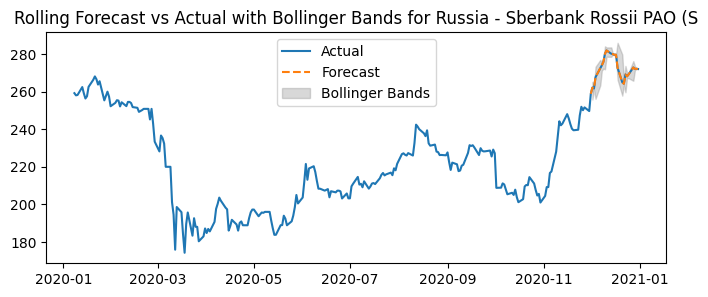

Processing sheet: Turkey - Koc Holding AS (KCHOL)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=240.788, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241.699, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=243.344, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=244.577, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=239.302, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=241.018, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=241.795, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=244.539, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=242.167, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=240.707, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=243.401, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=245.212, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=246.161, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=in

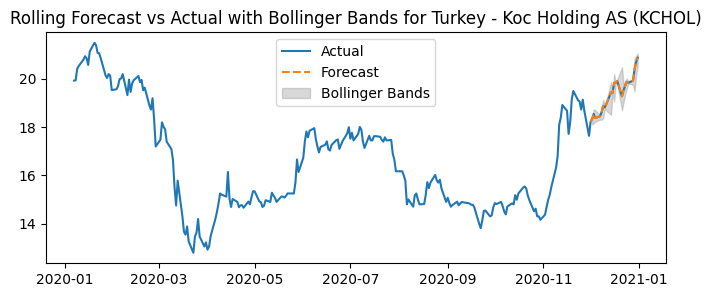

Processing sheet: Egypt - Medinet Nasr Housing (M
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-441.992, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-443.421, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-446.410, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-444.942, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-443.240, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-445.215, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-444.303, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-444.708, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-444.735, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-442.970, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-442.220, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-445.631, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-443.871, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-448.010, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] in

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

Mean Squared Error for Egypt - Medinet Nasr Housing (M (ARIMAX): 0.00015852902225695932
Mean Absolute Error for Egypt - Medinet Nasr Housing (M (ARIMAX): 0.009643136098712986
R2 Score for Egypt - Medinet Nasr Housing (M (ARIMAX): 0.9656613492859177
MAPE for Egypt - Medinet Nasr Housing (M (ARIMAX): 0.2556803339886578
SMAPE for Egypt - Medinet Nasr Housing (M (ARIMAX): 0.2551257736791


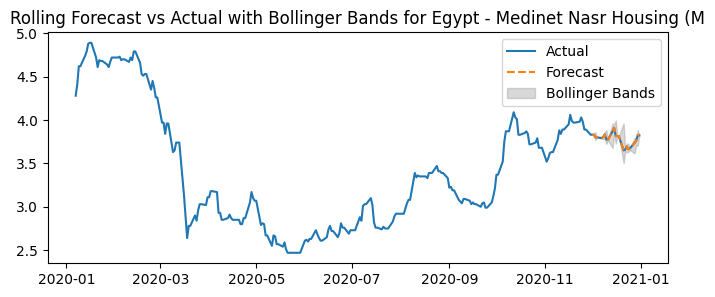

Processing sheet: Brazil - Minerva SABrazil (BEEF
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=261.679, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=262.520, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=259.286, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=255.427, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=256.695, Time=0.16 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=257.774, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=262.242, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=265.177, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=258.288, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=257.055, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=258.390, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=261.526, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=260.567, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=253.384, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

Mean Squared Error for Brazil - Minerva SABrazil (BEEF (ARIMAX): 0.01691804724917341
Mean Absolute Error for Brazil - Minerva SABrazil (BEEF (ARIMAX): 0.07716573315028125
R2 Score for Brazil - Minerva SABrazil (BEEF (ARIMAX): 0.7104779729807793
MAPE for Brazil - Minerva SABrazil (BEEF (ARIMAX): 0.7525309164082132
SMAPE for Brazil - Minerva SABrazil (BEEF (ARIMAX): 0.7603341101814604


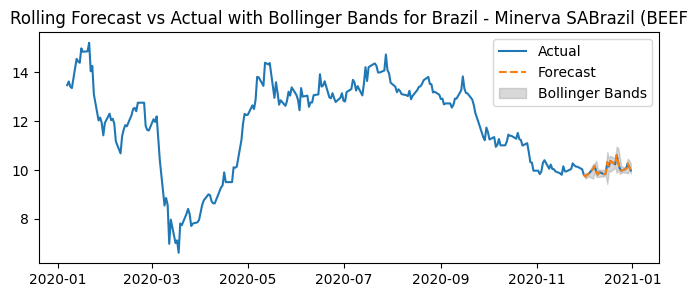

Processing sheet: Argentina - Pampa Energia SA (P
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=987.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=987.533, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=989.169, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=988.470, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=990.384, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=992.364, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=987.398, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=990.236, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=990.392, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=988.877, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.277, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=991.550, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=992.38

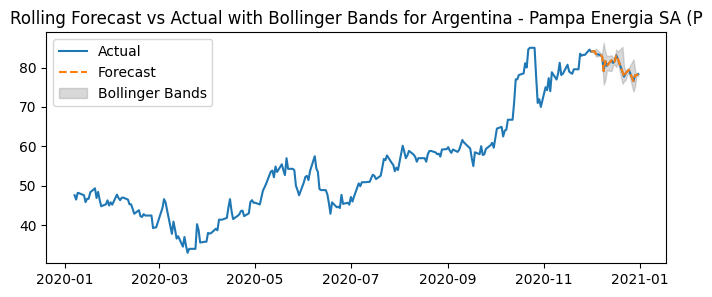

Processing sheet: Colombia - Cementos Argos SA (C
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3033.599, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3035.567, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3030.334, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3031.465, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3033.115, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3033.776, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3035.557, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3034.801, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3030.992, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3031.959, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3033.919, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3030.198, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3031.309, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3032.991, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] in

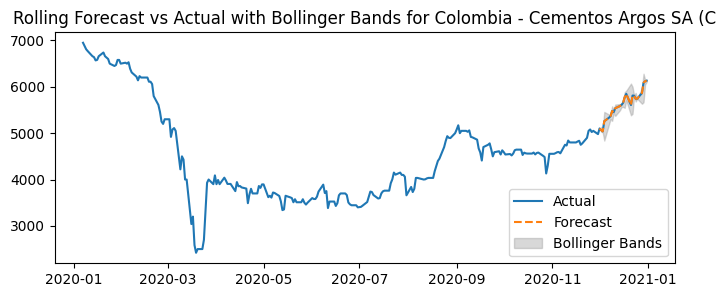

Processing sheet: South Africa - Impala Platinum 
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3701.139, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3703.099, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3704.910, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3703.472, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3705.123, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3704.716, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3703.095, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3705.130, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3706.369, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3705.289, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3704.923, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3706.509, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3697.445, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] interce

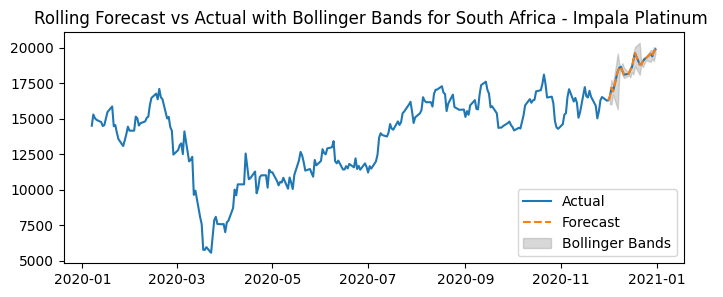

Processing sheet: South Korea - Dongkuk Steel Mil
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3194.377, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3195.508, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3195.136, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3196.713, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3197.998, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3198.861, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3195.333, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3196.244, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3196.651, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3198.600, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3199.731, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3195.123, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3196.812, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3197.058, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] in

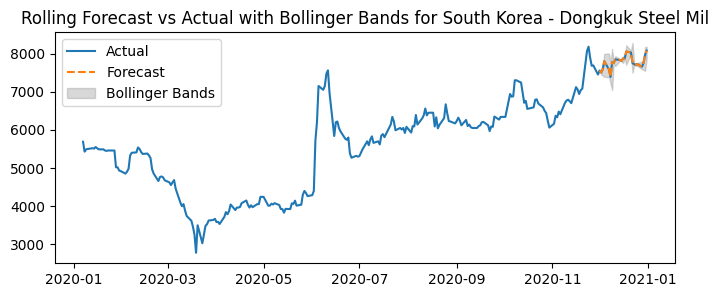

In [156]:
# Forecast for all sheets and measure performance
results_arimax, performance_metrics_arimax, models_arimax = ts_forecast_arimax(sheet_dict, target_col='Price', forecast_month='December', forecast_year=2020)


In [157]:
 performance_metrics_arimax

MAE        RMSE      MAPE     SMAPE  \
Russia - Sberbank Rossii PAO (S      1.4842    1.663816  0.547997  0.548397   
Turkey - Koc Holding AS (KCHOL)    0.104181    0.120242  0.528337  0.530134   
Egypt - Medinet Nasr Housing (M    0.009643    0.012591   0.25568  0.255126   
Brazil - Minerva SABrazil (BEEF    0.077166    0.130069  0.752531  0.760334   
Argentina - Pampa Energia SA (P    1.363294     1.51262  1.739154   1.72045   
Colombia - Cementos Argos SA (C   34.049171   41.361948  0.596787  0.597898   
South Africa - Impala Platinum   343.206709  391.757869  1.795689  1.816745   
South Korea - Dongkuk Steel Mil   82.524965   94.658589  1.048959  1.055316   

                                 R2 Score  
Russia - Sberbank Rossii PAO (S  0.934424  
Turkey - Koc Holding AS (KCHOL)  0.976725  
Egypt - Medinet Nasr Housing (M  0.965661  
Brazil - Minerva SABrazil (BEEF  0.710478  
Argentina - Pampa Energia SA (P  0.699589  
Colombia - Cementos Argos SA (C  0.984035  
South Africa - Impala Platinum   0.860229  
South Korea - Dongkuk Steel Mil  0.787046

### **1.4 Using Exogenous variables such as the previous values of the ARIMA model such as the Open, high, low, vol and change cols of the previous days as well as the exchange rates and doing it for all companies.**

In [ ]:
# Getting exchange rate information using Exchangerate API

import requests
import pandas as pd
from datetime import datetime, timedelta
from config import API_KEY

#ExchangeRate-API
ER_API_KEY = API_KEY
BASE_URL = 'https://v6.exchangerate-api.com/v6'

def fetch_exchange_rate(date, base_currency='USD' ):
    target_currency=['TRY', 'RUB', 'EGP', 'BRL', 'ARS', 'COP', 'ZAR', 'KRW']
    year = date.year
    month = date.month
    day = date.day
    url = f"{BASE_URL}/{ER_API_KEY}/history/{base_currency}/{year}/{month}/{day}"
    response = requests.get(url)
    data = response.json()
    currency_dict = dict()
    for currency in target_currency:
        if currency not in data['conversion_rates'].keys():
            currency_dict[currency] = None
        else:
            currency_dict[currency] = data['conversion_rates'][currency]
    return currency_dict

def get_exchange_rates_for_year(data, base_currency='USD'):
    start_date = data.index[0]
    end_date = data.index[-1]
    delta = timedelta(days=1)

    dates = []
    rates = pd.DataFrame()

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        try:
            rate = fetch_exchange_rate(current_date, base_currency)
            dates.append(date_str)
            rates = pd.concat([rates, pd.DataFrame(rate, index=[date_str])])
        except KeyError:
            # Handle the case where the rate is not available for a specific date
            print(f"Rate not available for {date_str}")
        current_date += delta

    return rates


# Save to CSV
exchange_rates_df = get_exchange_rates_for_year(data,  base_currency='USD')
exchange_rates_df.to_csv('usd_to_cur_2020.csv', index=True)


In [165]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def create_lagged_features(data, target_col, lags=3):
    lagged_data = data.copy()
    for column in data.columns:
        if column != target_col:
            for lag in range(1, lags + 1):
                lagged_data[f'{column}_lag{lag}'] = data[column].shift(lag)
    lagged_data.dropna(inplace=True)  # Drop rows with NaN values caused by lagging
    return lagged_data

def ts_forecast_arimax_wexg(sheet_dict, exchange_rates_df, target_col='Price', forecast_month='December', forecast_year=2020, lags=3):
    forecast_results = {}
    models = {}
    performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2 Score'])

    # Ensure exchange_rates_df has a frequency
    if exchange_rates_df.index.freq is None:
        exchange_rates_df.index.freq = pd.infer_freq(exchange_rates_df.index)
    if exchange_rates_df.index.freq is None:
        exchange_rates_df.index.freq = 'B'

    for sheet_name, df in sheet_dict.items():
        print(f"Processing sheet: {sheet_name}")

        # Ensure the datetime index has a frequency
        if df.index.freq is None:
            df.index.freq = pd.infer_freq(df.index)
        if df.index.freq is None:
            df.index.freq = 'B'

        # Merge with exchange_rates_df
        df = df.merge(exchange_rates_df, left_index=True, right_index=True, how='left')

        # Create lagged features for exogenous variables
        df = create_lagged_features(df, target_col, lags)

        # Determine the business days in the forecast month
        forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
        forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
        forecast_steps = len(forecast_index)

        # Split data into training and validation sets
        train_data = df.loc[df.index < forecast_start_date]
        val_data = df.loc[(df.index >= forecast_start_date) & (df.index <= forecast_end_date)]

        # Prepare lagged exogenous variables
        exog_cols = [col for col in train_data.columns if col != target_col]
        train_exog = train_data[exog_cols]
        val_exog = val_data[exog_cols]

        # Optimize ARIMA parameters with lagged exogenous variables
        auto_arima_model = auto_arima(train_data[target_col],
                                      exogenous=train_exog,
                                      start_p=0, start_q=0,
                                      max_p=10, max_q=10,
                                      seasonal=False,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=False)

        # Print the optimal order
        print(f'Optimal order: {auto_arima_model.order}')

        # Initialize a DataFrame to store the forecasts
        forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

        # Perform rolling forecast
        for i in range(forecast_steps):
            # Fit the model on the entire training dataset up to the current point
            model = ARIMA(train_data[target_col], order=auto_arima_model.order, exog=train_exog)
            results = model.fit(method_kwargs={"maxiter": 5000, "disp": 0})

            # Forecast the next step using past values of the exogenous variables
            forecast = results.forecast(steps=1, exog=val_exog.iloc[[i]])
            forecast_df.iloc[i] = forecast.values

            # Append the forecasted value to the training data
            new_train_data = pd.concat([train_data, val_data.iloc[[i]]])
            new_train_data.loc[val_data.index[i], target_col] = forecast.values[0]  # Use the forecasted value for the target column
            new_train_exog = pd.concat([train_exog, val_exog.iloc[[i]]])

            # Update training data
            train_data = new_train_data
            train_exog = new_train_exog

        # Store the trained model
        models[sheet_name] = model
        # Ensure forecast_df has a datetime index
        forecast_df.index = forecast_index

        # Evaluate ARIMA model
        mse_arima = mean_squared_error(val_data[target_col], forecast_df['Forecast'])
        mae_arima = mean_absolute_error(val_data[target_col], forecast_df['Forecast'])
        r2_arima = r2_score(val_data[target_col], forecast_df['Forecast'])
        mape_arima = np.mean(np.abs((val_data[target_col] - forecast_df['Forecast']) / val_data[target_col])) * 100
        smape_arima = np.mean(2 * np.abs(val_data[target_col] - forecast_df['Forecast']) / (np.abs(val_data[target_col]) + np.abs(forecast_df['Forecast']))) * 100

        # Store performance metrics
        performance_metrics.loc[sheet_name, 'MAE'] = mae_arima
        performance_metrics.loc[sheet_name, 'RMSE'] = np.sqrt(mse_arima)
        performance_metrics.loc[sheet_name, 'MAPE'] = mape_arima
        performance_metrics.loc[sheet_name, 'SMAPE'] = smape_arima
        performance_metrics.loc[sheet_name, 'R2 Score'] = r2_arima

        # Compute the Bollinger Bands
        rolling_mean = forecast_df['Forecast'].rolling(window=2).mean()
        rolling_std = forecast_df['Forecast'].rolling(window=2).std()
        forecast_df['Upper Band'] = rolling_mean + (rolling_std * 2)
        forecast_df['Lower Band'] = rolling_mean - (rolling_std * 2)

        # Plot the actual vs forecasted values with Bollinger Bands
        plt.figure(figsize=(8, 3))
        plt.plot(train_data.index, train_data[target_col], label='Actual')
        plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
        plt.fill_between(forecast_df.index, forecast_df['Upper Band'], forecast_df['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
        plt.legend(loc='best')
        plt.title(f'Rolling Forecast vs Actual with Bollinger Bands for {sheet_name}')
        plt.show()

        forecast_results[sheet_name] = forecast_df

    return forecast_results, performance_metrics, models

Processing sheet: Russia - Sberbank Rossii PAO (S
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1397.968, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1399.878, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1401.684, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1403.585, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1389.180, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1389.503, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1399.884, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1401.783, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1403.681, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1399.763, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1390.136, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1401.605, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1403.453, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1392.868, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] in

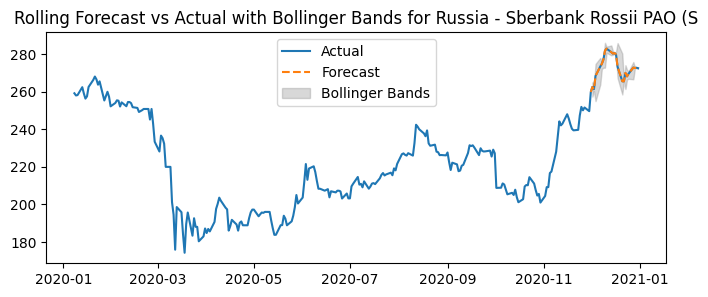

Processing sheet: Turkey - Koc Holding AS (KCHOL)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=240.788, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241.699, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=243.344, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=244.577, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=239.302, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=241.018, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=241.795, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=244.539, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=242.167, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=240.707, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=243.401, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=245.212, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=246.161, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=in

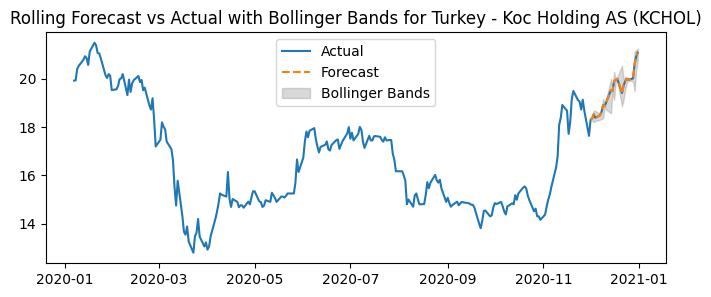

Processing sheet: Egypt - Medinet Nasr Housing (M
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-441.992, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-443.421, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-446.410, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-444.942, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-443.240, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-445.215, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-444.303, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-444.708, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-444.735, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-442.970, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-442.220, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-445.631, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-443.871, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-448.010, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] in

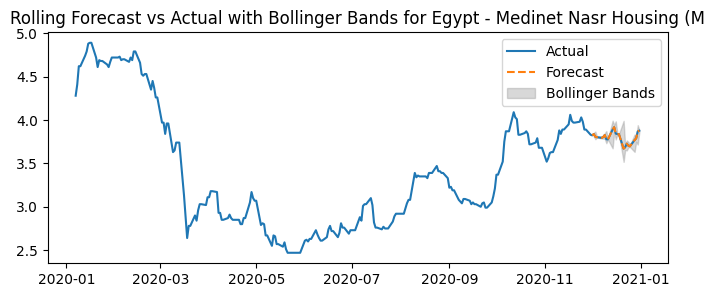

Processing sheet: Brazil - Minerva SABrazil (BEEF
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=261.679, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=262.520, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=259.286, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=255.427, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=256.695, Time=0.16 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=257.774, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=262.242, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=265.177, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=258.288, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=257.055, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=258.390, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=261.526, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=260.567, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=253.384, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

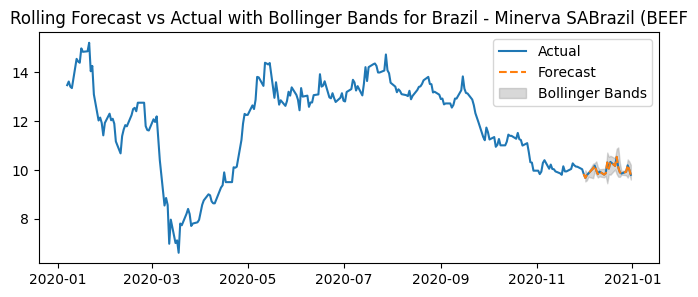

Processing sheet: Argentina - Pampa Energia SA (P
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=987.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=987.533, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=989.169, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=988.470, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=990.384, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=992.364, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=987.398, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=990.236, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=990.392, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=988.877, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.277, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=991.550, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=992.38

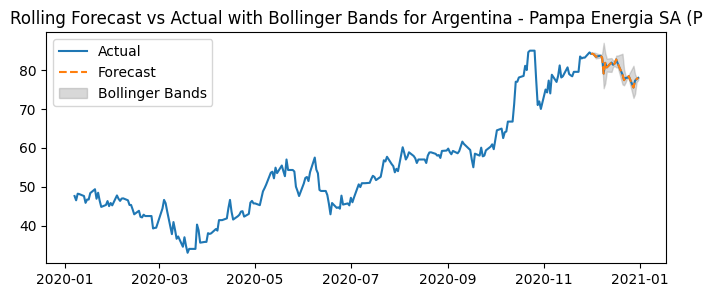

Processing sheet: Colombia - Cementos Argos SA (C
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3033.599, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3035.567, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3030.334, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3031.465, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3033.115, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3033.776, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3035.557, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3034.801, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3030.992, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3031.959, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3033.919, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3030.198, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3031.309, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3032.991, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] in

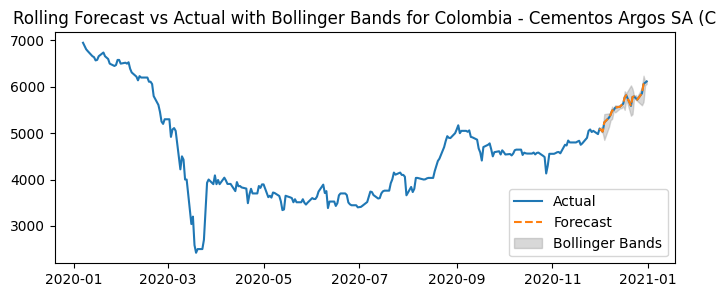

Processing sheet: South Africa - Impala Platinum 
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3701.139, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3703.099, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3704.910, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3703.472, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3705.123, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3704.716, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3703.095, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3705.130, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3706.369, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3705.289, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3704.923, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3706.509, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3697.445, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] interce

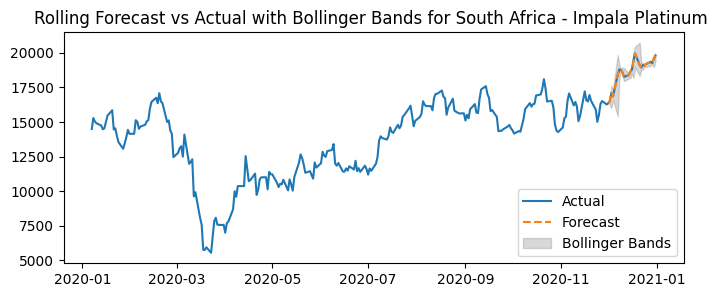

Processing sheet: South Korea - Dongkuk Steel Mil
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3194.377, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3195.508, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3195.136, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3196.713, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3197.998, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3198.861, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3195.333, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3196.244, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3196.651, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3198.600, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3199.731, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3195.123, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3196.812, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3197.058, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] in

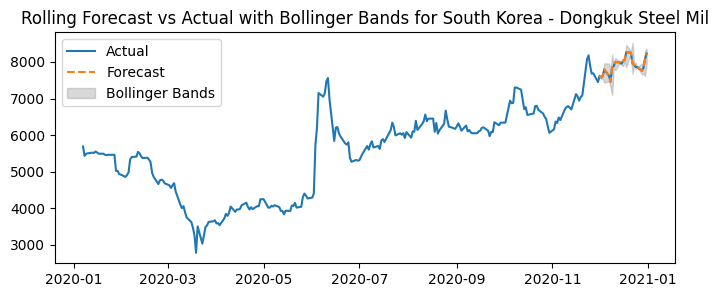

In [166]:
# Load the exchange rates data
exchange_rates_df = pd.read_csv('/content/gdrive/My Drive/usd_to_cur_2020.csv', index_col='Date', parse_dates=True)

# Forecast for all sheets and measure performance
results_arimax_wexg, performance_metrics_arimax_wexg, models_arimax_wexg = ts_forecast_arimax_wexg(sheet_dict, exchange_rates_df, target_col='Price', forecast_month='December', forecast_year=2020)

In [167]:
 performance_metrics_arimax_wexg

MAE        RMSE      MAPE     SMAPE  \
Russia - Sberbank Rossii PAO (S     1.40943    1.695863  0.522017  0.521078   
Turkey - Koc Holding AS (KCHOL)    0.042556    0.055207  0.221775  0.221902   
Egypt - Medinet Nasr Housing (M    0.028206    0.032182   0.75039  0.746755   
Brazil - Minerva SABrazil (BEEF    0.133173     0.20158  1.298063  1.316938   
Argentina - Pampa Energia SA (P    1.241701     1.36408  1.571298  1.556748   
Colombia - Cementos Argos SA (C   43.343395   51.772623  0.758479  0.760738   
South Africa - Impala Platinum   285.393826  346.114324  1.493527    1.5097   
South Korea - Dongkuk Steel Mil   73.062157   89.213501  0.936881  0.931302   

                                 R2 Score  
Russia - Sberbank Rossii PAO (S  0.931874  
Turkey - Koc Holding AS (KCHOL)  0.995094  
Egypt - Medinet Nasr Housing (M  0.775669  
Brazil - Minerva SABrazil (BEEF  0.304612  
Argentina - Pampa Energia SA (P  0.755693  
Colombia - Cementos Argos SA (C  0.974986  
South Africa - Impala Platinum   0.890901  
South Korea - Dongkuk Steel Mil  0.810841

### **2 Using LSTM to predict the next days price and doing it for all companies.**

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])
        y.append(data[i + seq_length, 0])  # Adjust to use the first column, assuming single feature
    return np.array(X), np.array(y)

def ts_forecast_lstm(sheet_dict, target_col='Price', forecast_month='December', forecast_year=2020, seq_length=5):
    forecast_results = {}
    models = {}
    performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2 Score'])


    for sheet_name, df in sheet_dict.items():
        print(f"Processing sheet: {sheet_name}")

        # Ensure the datetime index has a frequency
        if df.index.freq is None:
            df.index.freq = pd.infer_freq(df.index)
        if df.index.freq is None:  # If still None, set to business day frequency
            df.index.freq = 'B'

        # Determine the business days in the forecast month
        forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
        forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
        forecast_steps = len(forecast_index)

        # Split data into training and validation sets for forecasting
        train_data = df.loc[df.index < forecast_start_date]
        val_data = df.loc[(df.index >= forecast_start_date) & (df.index <= forecast_end_date)]

        # Scale the data
        scaler = MinMaxScaler()
        scaled_train = scaler.fit_transform(train_data[[target_col]])
        scaled_val = scaler.transform(val_data[[target_col]])

        # Prepare sequences
        X_train, y_train = create_sequences(scaled_train, seq_length)

        # Split the training data into training and early stopping validation sets
        early_stop_val_split = int(len(X_train) * 0.8)
        X_train_main, X_train_early_stop = X_train[:early_stop_val_split], X_train[early_stop_val_split:]
        y_train_main, y_train_early_stop = y_train[:early_stop_val_split], y_train[early_stop_val_split:]


        # Build the LSTM model
        def build_lstm_model():
            model = Sequential()
            model.add(LSTM(32))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_squared_error')
            return model

        # Instantiate the LSTM model
        model_lstm = build_lstm_model()

        # Add early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Model fitting
        model_lstm.fit(X_train_main, y_train_main, epochs=50, batch_size=32, validation_data=(X_train_early_stop, y_train_early_stop), callbacks=[early_stopping], verbose=1)

        # Store the trained model
        models[sheet_name] = model_lstm

        # Initialize a DataFrame to store the forecasts
        forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

        # Perform rolling forecast
        last_sequence = scaled_train[-seq_length:]  # Get the last sequence from the training data

        for i in range(forecast_steps):
            X_last = np.expand_dims(last_sequence, axis=0)  # Shape to (1, seq_length, num_features)
            y_pred = model_lstm.predict(X_last)[0, 0]  # Predict the next value

            # Append the forecasted value to the forecast DataFrame
            forecast_df.iloc[i] = y_pred

            # Update the last sequence with the true value from the validation set
            if i < len(scaled_val):
                new_sequence = np.append(last_sequence[1:], scaled_val[i].reshape(1, -1), axis=0)
                last_sequence = new_sequence

        # Inverse transform to the original scale
        forecast_df["Forecast"] = scaler.inverse_transform(forecast_df[["Forecast"]].values).flatten()


        # Evaluate the model
        mse_lstm = mean_squared_error(val_data[target_col], forecast_df["Forecast"])
        mae_lstm = mean_absolute_error(val_data[target_col], forecast_df["Forecast"])
        r2_lstm = r2_score(val_data[target_col], forecast_df["Forecast"])
        mape_lstm = np.mean(np.abs((val_data[target_col] - forecast_df["Forecast"]) / val_data[target_col])) * 100
        smape_lstm = np.mean(2 * np.abs(val_data[target_col] - forecast_df["Forecast"]) / (np.abs(val_data[target_col]) + np.abs(forecast_df["Forecast"]))) * 100

        # Store performance metrics
        performance_metrics.loc[sheet_name, 'MAE'] = mae_lstm
        performance_metrics.loc[sheet_name, 'RMSE'] = np.sqrt(mse_lstm)
        performance_metrics.loc[sheet_name, 'MAPE'] = mape_lstm
        performance_metrics.loc[sheet_name, 'SMAPE'] = smape_lstm
        performance_metrics.loc[sheet_name, 'R2 Score'] = r2_lstm


        # Compute the Bollinger Bands
        rolling_mean = forecast_df['Forecast'].rolling(window=2).mean()
        rolling_std = forecast_df['Forecast'].rolling(window=2).std()
        forecast_df['Upper Band'] = rolling_mean + (rolling_std * 2)
        forecast_df['Lower Band'] = rolling_mean - (rolling_std * 2)

        # Plot the actual vs forecasted values with Bollinger Bands
        plt.figure(figsize=(8, 3))
        combined_data = pd.concat([train_data[target_col], val_data[target_col]])
        plt.plot(combined_data.index, combined_data, label='Actual')
        plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
        plt.fill_between(forecast_df.index, forecast_df['Upper Band'], forecast_df['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
        plt.legend(loc='best')
        plt.title(f'Rolling Forecast vs Actual with Bollinger Bands for {sheet_name}')
        plt.show()

        forecast_results[sheet_name] = forecast_df

    return forecast_results, performance_metrics, models

Processing sheet: Russia - Sberbank Rossii PAO (S
Epoch 1/50
6/6 [==============================] - 3s 100ms/step - loss: 0.2741 - val_loss: 0.2303
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1817 - val_loss: 0.1458
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1057 - val_loss: 0.0802
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0569 - val_loss: 0.0364
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0268 - val_loss: 0.0147
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0114
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0124
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0179 - val_loss: 0.0110
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.0106
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0130 

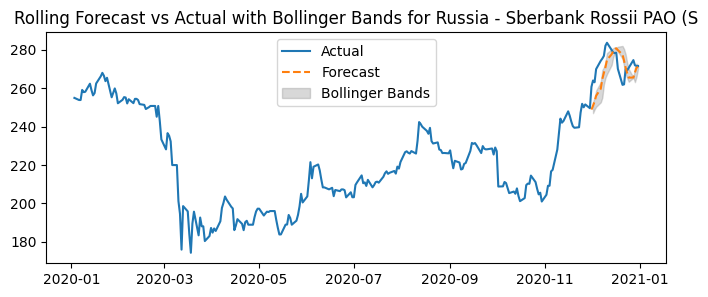

Processing sheet: Turkey - Koc Holding AS (KCHOL)
Epoch 1/50
6/6 [==============================] - 3s 96ms/step - loss: 0.1784 - val_loss: 0.0994
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1103 - val_loss: 0.0593
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0664 - val_loss: 0.0311
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.0155
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0193 - val_loss: 0.0122
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0175 - val_loss: 0.0137
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0180 - val_loss: 0.0123
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0173 - val_loss: 0.0106
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0127 - val_

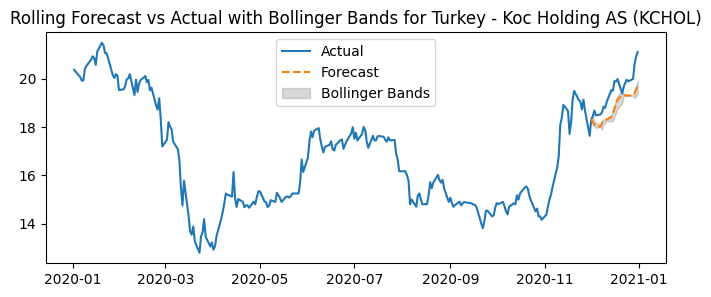

Processing sheet: Egypt - Medinet Nasr Housing (M
Epoch 1/50
6/6 [==============================] - 3s 97ms/step - loss: 0.1630 - val_loss: 0.1753
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1086 - val_loss: 0.1109
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0681 - val_loss: 0.0602
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0421 - val_loss: 0.0240
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0277 - val_loss: 0.0062
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0211 - val_loss: 0.0033
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0199 - val_loss: 0.0034
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0167 - val_loss: 0.0037
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0119 - val_loss: 0.0062
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0118 -

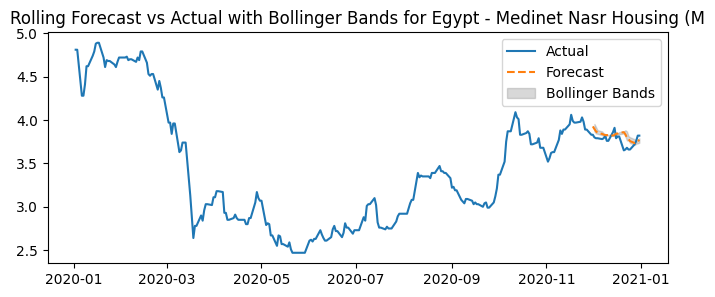

Processing sheet: Brazil - Minerva SABrazil (BEEF
Epoch 1/50
6/6 [==============================] - 3s 94ms/step - loss: 0.6934 - val_loss: 0.2674
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.5194 - val_loss: 0.1828
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3777 - val_loss: 0.1166
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.2572 - val_loss: 0.0657
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1626 - val_loss: 0.0288
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0968 - val_loss: 0.0073
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0468 - val_loss: 0.0020
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0326 - val_loss: 0.0098
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0274 - val_loss: 0.0199
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0258 - v

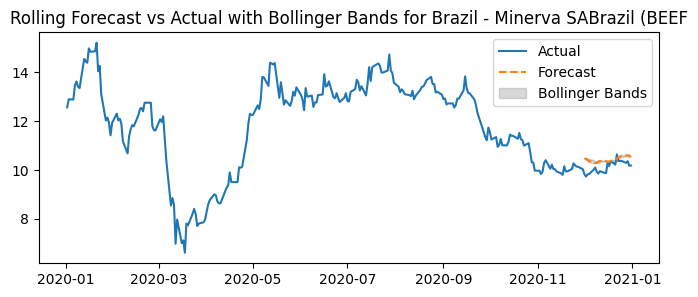

Processing sheet: Argentina - Pampa Energia SA (P
Epoch 1/50
6/6 [==============================] - 3s 94ms/step - loss: 0.1111 - val_loss: 0.5880
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0776 - val_loss: 0.4494
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0495 - val_loss: 0.3265
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.2196
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0153 - val_loss: 0.1335
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0772
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0091 - val_loss: 0.0511
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0098 - val_loss: 0.0502
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0084 - val_loss: 0.0642
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0076 - val

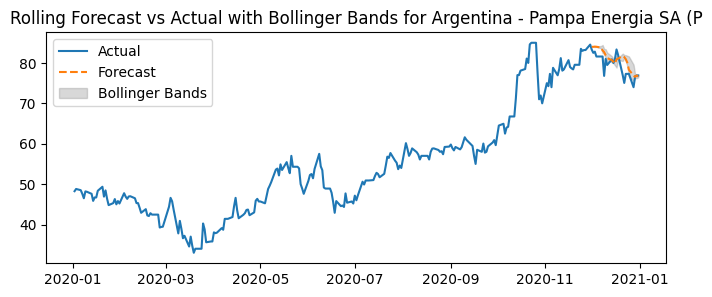

Processing sheet: Colombia - Cementos Argos SA (C
Epoch 1/50
6/6 [==============================] - 3s 93ms/step - loss: 0.1963 - val_loss: 0.1443
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1210 - val_loss: 0.0791
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0619 - val_loss: 0.0340
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0333 - val_loss: 0.0085
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 8.4070e-04
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0021
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0167 - val_loss: 0.0019
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 7.6552e-04
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.0010
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0124

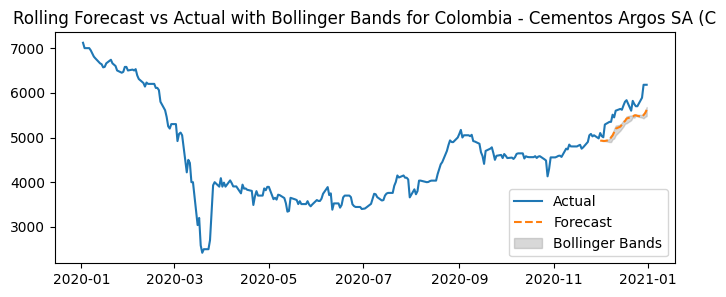

Processing sheet: South Africa - Impala Platinum 
Epoch 1/50
6/6 [==============================] - 3s 97ms/step - loss: 0.2821 - val_loss: 0.3918
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1910 - val_loss: 0.2690
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1249 - val_loss: 0.1637
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0679 - val_loss: 0.0791
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0333 - val_loss: 0.0244
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0174 - val_loss: 0.0055
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0187 - val_loss: 0.0051
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0047
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0160 - val_loss: 0.0069
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0149

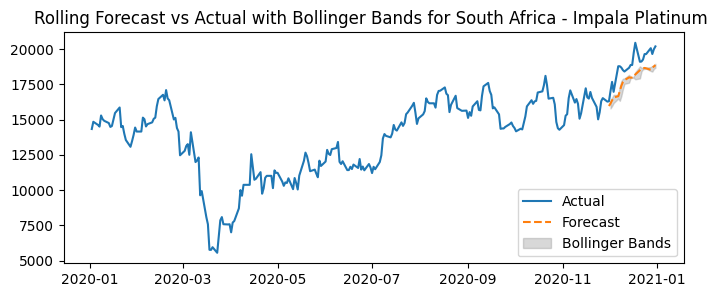

Processing sheet: South Korea - Dongkuk Steel Mil
Epoch 1/50
6/6 [==============================] - 3s 93ms/step - loss: 0.1939 - val_loss: 0.4037
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1371 - val_loss: 0.2830
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0835 - val_loss: 0.1797
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0447 - val_loss: 0.0957
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0241 - val_loss: 0.0383
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0161 - val_loss: 0.0066
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0160 - val_loss: 0.0086
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0120 - val_

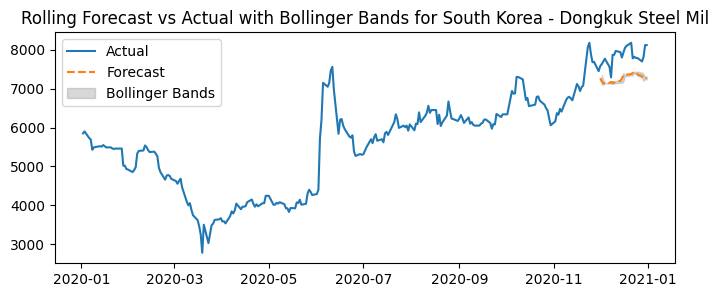

In [116]:
results_lstm, performance_metrics_lstm, models_lstm = ts_forecast_lstm(sheet_dict, target_col='Price', forecast_month='December', forecast_year=2020, seq_length = 5)


In [109]:
 performance_metrics_lstm

MAE         RMSE      MAPE     SMAPE  \
Russia - Sberbank Rossii PAO (S   10.238607    11.339295  3.765769  3.844693   
Turkey - Koc Holding AS (KCHOL)    0.635856     0.724165  3.219452  3.286702   
Egypt - Medinet Nasr Housing (M    0.066951     0.080766  1.787131  1.770723   
Brazil - Minerva SABrazil (BEEF    0.172415     0.217336  1.720847  1.707358   
Argentina - Pampa Energia SA (P    2.744064     3.413591  3.494146  3.401578   
Colombia - Cementos Argos SA (C  471.478932   504.313044  8.249906  8.648238   
South Africa - Impala Platinum   1204.89904  1308.633947  6.314857  6.556285   
South Korea - Dongkuk Steel Mil  426.146379   467.551968  5.386991  5.565982   

                                 R2 Score  
Russia - Sberbank Rossii PAO (S -2.045814  
Turkey - Koc Holding AS (KCHOL)  0.155801  
Egypt - Medinet Nasr Housing (M -0.412967  
Brazil - Minerva SABrazil (BEEF  0.191656  
Argentina - Pampa Energia SA (P -0.529959  
Colombia - Cementos Argos SA (C -1.373438  
South Africa - Impala Platinum  -0.559617  
South Korea - Dongkuk Steel Mil -4.195477

## **2. Timeseries forecasting using DARTS**

### **2.1 Using the DARTS toolbox to implement the NBEATS models. The NBEATS model in DARTS can learn from multiple series**

In [180]:
# Nbeats model

from darts.metrics import mae, rmse, mape, smape, mase, r2_score
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import logging
from darts import concatenate
from darts.utils.likelihood_models import GaussianLikelihood, LaplaceLikelihood

logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

def ts_forecast_darts_NBEATS(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020):

  # Determine the business days in the validation data
  val_start_date = pd.Timestamp(f'{val_year}-{val_month}-01')
  val_end_date = pd.Timestamp(f'{val_year}-{val_month}-01')+ pd.DateOffset(months=1) - pd.DateOffset(days=1)
  val_index = pd.date_range(start=val_start_date, end=val_end_date, freq='B')
  val_steps = len(val_index)

  # Check if past_covariates
  if past_covariates_df is not None:
      past_covariates_df.sort_index(ascending=True, inplace=True)


  # Initialize empty lists for series
  target_series = []
  exog_series= []
  train_series= []
  test_series= []
  train_exog= []
  test_exog= []
  train_sub_series= []
  val_series= []
  val_exog= []
  train_sub_exog= []

 # Initalize results
  forecast_results = {}
  models = {}
  performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R2 Score'])
  for company, df_comp in sheet_dict.items():
      # Sort the DataFrame
      df_comp.sort_index(ascending=True, inplace=True)

      # Append target and exogenous DataFrame
      tseries= TimeSeries.from_series(df_comp[[target_col]])
      train_series_comp, test_series_comp = tseries.split_before(test_start_date)
      train_sub_series_comp, val_series_comp = train_series_comp.split_before(val_start_date)
      target_series.append(tseries)
      train_series.append(train_series_comp)
      test_series.append(test_series_comp)
      train_sub_series.append(train_sub_series_comp)
      val_series.append(val_series_comp)

      exog_cols = [col for col in df_comp.columns if col != target_col]
      if exog_cols:
          if past_covariates_df is None:
              eseries = TimeSeries.from_dataframe(df_comp[exog_cols])
          else:
              past_covariates= TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries = concatenate([past_covariates, TimeSeries.from_dataframe(df_comp[exog_cols])], axis=1)
      else:
          if past_covariates_df is not None:
              past_covariates = TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries= past_covariates

      exog_series.append(eseries)
      train_exog_comp, test_exog_comp = eseries.split_before(test_start_date)
      train_sub_exog_comp, val_exog_comp = train_exog_comp.split_before(val_start_date)
      train_exog.append(train_exog_comp)
      test_exog.append(test_exog_comp)
      train_sub_exog.append(train_sub_exog_comp)
      val_exog.append(val_exog_comp)


  # Scale the data
  scaler_target = Scaler()
  scaler_exog = Scaler()
  train_sub_series_scaled = scaler_target.fit_transform(train_sub_series)
  train_series_scaled = scaler_target.transform(train_series)
  test_series_scaled = scaler_target.transform(test_series)
  train_sub_exog_scaled = scaler_exog.fit_transform(train_sub_exog)
  train_exog_scaled = scaler_exog.transform(train_exog)
  test_exog_scaled = scaler_exog.transform(test_exog)
  val_series_scaled = scaler_target.transform(val_series)
  val_exog_scaled = scaler_exog.transform(val_exog)

  # Define and train the NBEATS model
  model = NBEATSModel(input_chunk_length=100,
                    output_chunk_length=1, random_state=0,
                      likelihood=LaplaceLikelihood(prior_b=0.1))

  model.fit(list(train_sub_series_scaled),
          past_covariates=list(train_sub_exog_scaled),
      epochs=100, verbose=True)

  pred_series = model.predict(n=val_steps,  num_samples=100,
                              series= train_sub_series_scaled,
                              past_covariates= train_exog_scaled)

  # Model
  models['model'] = model
  models['scale_target'] = scaler_target
  models['scale_exog'] =  scaler_exog

  # Unscaled forecast
  pred_series_unscaled = scaler_target.inverse_transform(pred_series)

  # Plotting and saving the forecast results
  plt.figure(figsize=(20, 15))
  for i, company in enumerate(sheet_dict.keys()):
    forecasts_df = pd.DataFrame(index=val_index, columns=['Forecast', 'Upper bound (75%ile)', 'Lower bound (25%ile)'])
    forecasts_df['Forecast'] = pred_series_unscaled[i].median().pd_series()
    forecasts_df['Upper bound (75%ile)'] = pred_series_unscaled[i].quantile(0.75).pd_series()
    forecasts_df['Lower bound (25%ile)'] = pred_series_unscaled[i].quantile(0.25).pd_series()
    forecast_results[company] = forecasts_df
    plt.subplot((len(sheet_dict.keys()) + 1) // 2, 2, i + 1)
    train_sub_series[i].plot(label="Train Data")
    val_series[i].plot(label="Actual")
    pred_series_unscaled[i].plot(label="Forecast")
    plt.title(f'NBEATS Forecast for {company}')
    plt.legend()
  plt.tight_layout()
  plt.show()

  # Evaluate the performance of the model

  for i, company in enumerate(sheet_dict.keys()):
      performance_metrics.loc[company, 'MAE'] = mae(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'RMSE'] = rmse(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MAPE'] = mape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'SMAPE'] = smape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MASE'] = mase(val_series[i], pred_series_unscaled[i], train_series[i])
      performance_metrics.loc[company, 'R2 Score'] = r2_score(val_series[i], pred_series_unscaled[i])

  return forecast_results, performance_metrics, models


INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 17.1 M | train
-------------------------------------------------------------
17.0 M    Trainable params
9.7 K     Non-trainable params
17.1 M    Total params
68.205    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

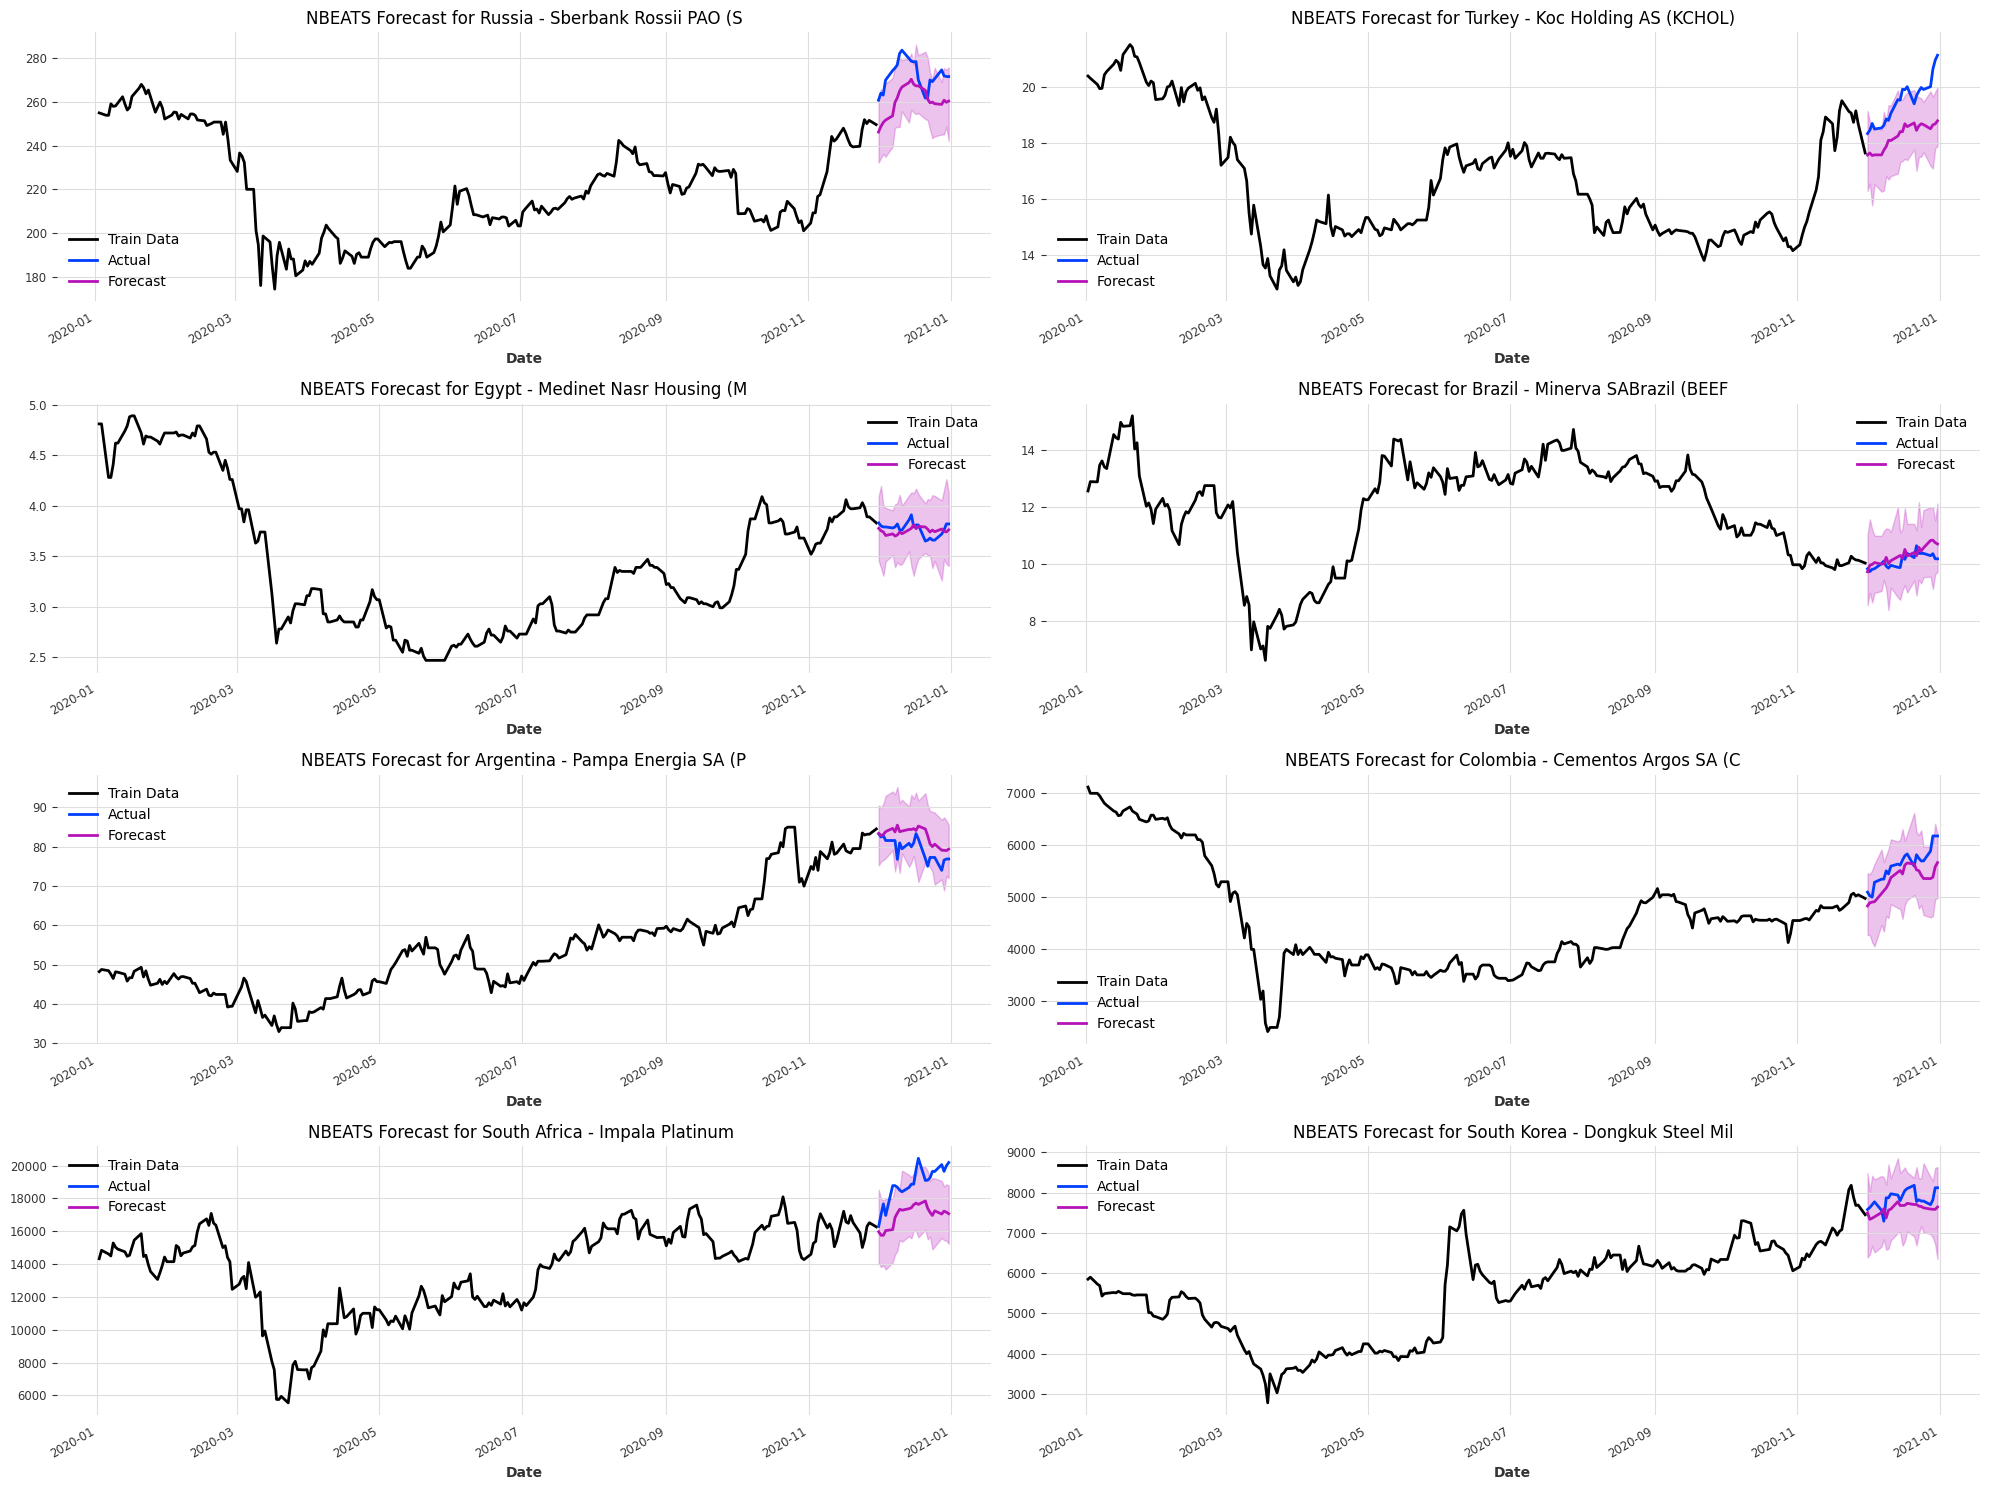

In [181]:
exchange_rates_df= pd.read_csv('/content/gdrive/My Drive/usd_to_cur_2020.csv', index_col='Date', parse_dates=True)
forecast_results_nbeats, performance_metrics_nbeats, model_nbeats = ts_forecast_darts_NBEATS(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020)

In [182]:
performance_metrics_nbeats

MAE         RMSE      MAPE  \
Russia - Sberbank Rossii PAO (S    11.980972    12.916999  4.388164   
Turkey - Koc Holding AS (KCHOL)     1.238345     1.314382  6.286088   
Egypt - Medinet Nasr Housing (M     0.067076     0.076041  1.781693   
Brazil - Minerva SABrazil (BEEF     0.257835     0.303407  2.545805   
Argentina - Pampa Energia SA (P     3.350542     4.015793  4.288065   
Colombia - Cementos Argos SA (C   286.520698   334.751747  5.005026   
South Africa - Impala Platinum   1880.342354  2022.263822   9.80322   
South Korea - Dongkuk Steel Mil   272.621801   308.469501  3.456027   

                                     SMAPE      MASE  R2 Score  
Russia - Sberbank Rossii PAO (S   4.502198  3.644402 -2.952342  
Turkey - Koc Holding AS (KCHOL)    6.51156  4.158227 -1.781078  
Egypt - Medinet Nasr Housing (M   1.784749  1.150298 -0.252487  
Brazil - Minerva SABrazil (BEEF   2.508416  0.887664 -0.575365  
Argentina - Pampa Energia SA (P   4.158523  2.341033 -1.117383  
Colombia - Cementos Argos SA (C   5.175324  3.045632 -0.045739  
South Africa - Impala Platinum   10.381882  3.892402 -2.724409  
South Korea - Dongkuk Steel Mil   3.525791  2.026705 -1.261466

### **2.2 Using the DARTS toolbox to implement the BLOCK-RNN model which can also use past covariates**

In [199]:
from darts.metrics import mae, rmse, mape, smape, mase, r2_score
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.block_rnn_model import BlockRNNModel
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import logging
from darts import concatenate
from darts.utils.likelihood_models import GaussianLikelihood, LaplaceLikelihood

logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

def ts_forecast_darts_BLOCK_LSTM(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020):

  # Determine the business days in the validation data
  val_start_date = pd.Timestamp(f'{val_year}-{val_month}-01')
  val_end_date = pd.Timestamp(f'{val_year}-{val_month}-01')+ pd.DateOffset(months=1) - pd.DateOffset(days=1)
  val_index = pd.date_range(start=val_start_date, end=val_end_date, freq='B')
  val_steps = len(val_index)

  # Check if past_covariates
  if past_covariates_df is not None:
      past_covariates_df.sort_index(ascending=True, inplace=True)
  # Initialize empty lists for series
  target_series = []
  exog_series= []
  train_series= []
  test_series= []
  train_exog= []
  test_exog= []
  train_sub_series= []
  val_series= []
  val_exog= []
  train_sub_exog= []

 # Initalize results
  forecast_results = {}
  models = {}
  performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R2 Score'])
  for company, df_comp in sheet_dict.items():
      # Sort the DataFrame
      df_comp.sort_index(ascending=True, inplace=True)

      # Append target and exogenous DataFrame
      tseries= TimeSeries.from_series(df_comp[[target_col]])
      train_series_comp, test_series_comp = tseries.split_before(test_start_date)
      train_sub_series_comp, val_series_comp = train_series_comp.split_before(val_start_date)
      target_series.append(tseries)
      train_series.append(train_series_comp)
      test_series.append(test_series_comp)
      train_sub_series.append(train_sub_series_comp)
      val_series.append(val_series_comp)

      exog_cols = [col for col in df_comp.columns if col != target_col]
      if exog_cols:
          if past_covariates_df is None:
              eseries = TimeSeries.from_dataframe(df_comp[exog_cols])
          else:
              past_covariates= TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries = concatenate([past_covariates, TimeSeries.from_dataframe(df_comp[exog_cols])], axis=1)
      else:
          if past_covariates_df is not None:
              past_covariates = TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries= past_covariates

      exog_series.append(eseries)
      train_exog_comp, test_exog_comp = eseries.split_before(test_start_date)
      train_sub_exog_comp, val_exog_comp = train_exog_comp.split_before(val_start_date)
      train_exog.append(train_exog_comp)
      test_exog.append(test_exog_comp)
      train_sub_exog.append(train_sub_exog_comp)
      val_exog.append(val_exog_comp)


  # Scale the data
  scaler_target = Scaler()
  scaler_exog = Scaler()
  train_sub_series_scaled = scaler_target.fit_transform(train_sub_series)
  train_series_scaled = scaler_target.transform(train_series)
  test_series_scaled = scaler_target.transform(test_series)
  train_sub_exog_scaled = scaler_exog.fit_transform(train_sub_exog)
  train_exog_scaled = scaler_exog.transform(train_exog)
  test_exog_scaled = scaler_exog.transform(test_exog)
  val_series_scaled = scaler_target.transform(val_series)
  val_exog_scaled = scaler_exog.transform(val_exog)

  # Define and train the Block RNN model
  model = BlockRNNModel(input_chunk_length=100,
                    output_chunk_length=1, random_state=0, model='LSTM',
                      likelihood=LaplaceLikelihood(prior_b=0.1))

  model.fit(list(train_sub_series_scaled),
          past_covariates=list(train_sub_exog_scaled),
      epochs=100, verbose=True)

  pred_series = model.predict(n=val_steps,  num_samples=100,
                              series= train_sub_series_scaled,
                              past_covariates= train_exog_scaled,
                              show_warnings=False)

  # Model
  models['model'] = model
  models['scale_target'] = scaler_target
  models['scale_exog'] =  scaler_exog

  # Unscaled forecast
  pred_series_unscaled = scaler_target.inverse_transform(pred_series)

  # Plotting and saving the forecast results
  plt.figure(figsize=(20, 15))
  for i, company in enumerate(sheet_dict.keys()):
    forecasts_df = pd.DataFrame(index=val_index, columns=['Forecast', 'Upper bound (75%ile)', 'Lower bound (25%ile)'])
    forecasts_df['Forecast'] = pred_series_unscaled[i].median().pd_series()
    forecasts_df['Upper bound (75%ile)'] = pred_series_unscaled[i].quantile(0.75).pd_series()
    forecasts_df['Lower bound (25%ile)'] = pred_series_unscaled[i].quantile(0.25).pd_series()
    forecast_results[company] = forecasts_df
    plt.subplot((len(sheet_dict.keys()) + 1) // 2, 2, i + 1)
    train_sub_series[i].plot(label="Train Data")
    val_series[i].plot(label="Actual")
    pred_series_unscaled[i].plot(label="Forecast")
    plt.title(f'BLOCK_LSTM Forecast for {company}')
    plt.legend()
  plt.tight_layout()
  plt.show()

  # Evaluate the performance of the model

  for i, company in enumerate(sheet_dict.keys()):
      performance_metrics.loc[company, 'MAE'] = mae(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'RMSE'] = rmse(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MAPE'] = mape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'SMAPE'] = smape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MASE'] = mase(val_series[i], pred_series_unscaled[i], train_series[i])
      performance_metrics.loc[company, 'R2 Score'] = r2_score(val_series[i], pred_series_unscaled[i])

  return forecast_results, performance_metrics, models



INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.1 K  | train
6 | fc              | Sequential       | 52     | train
-------------------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

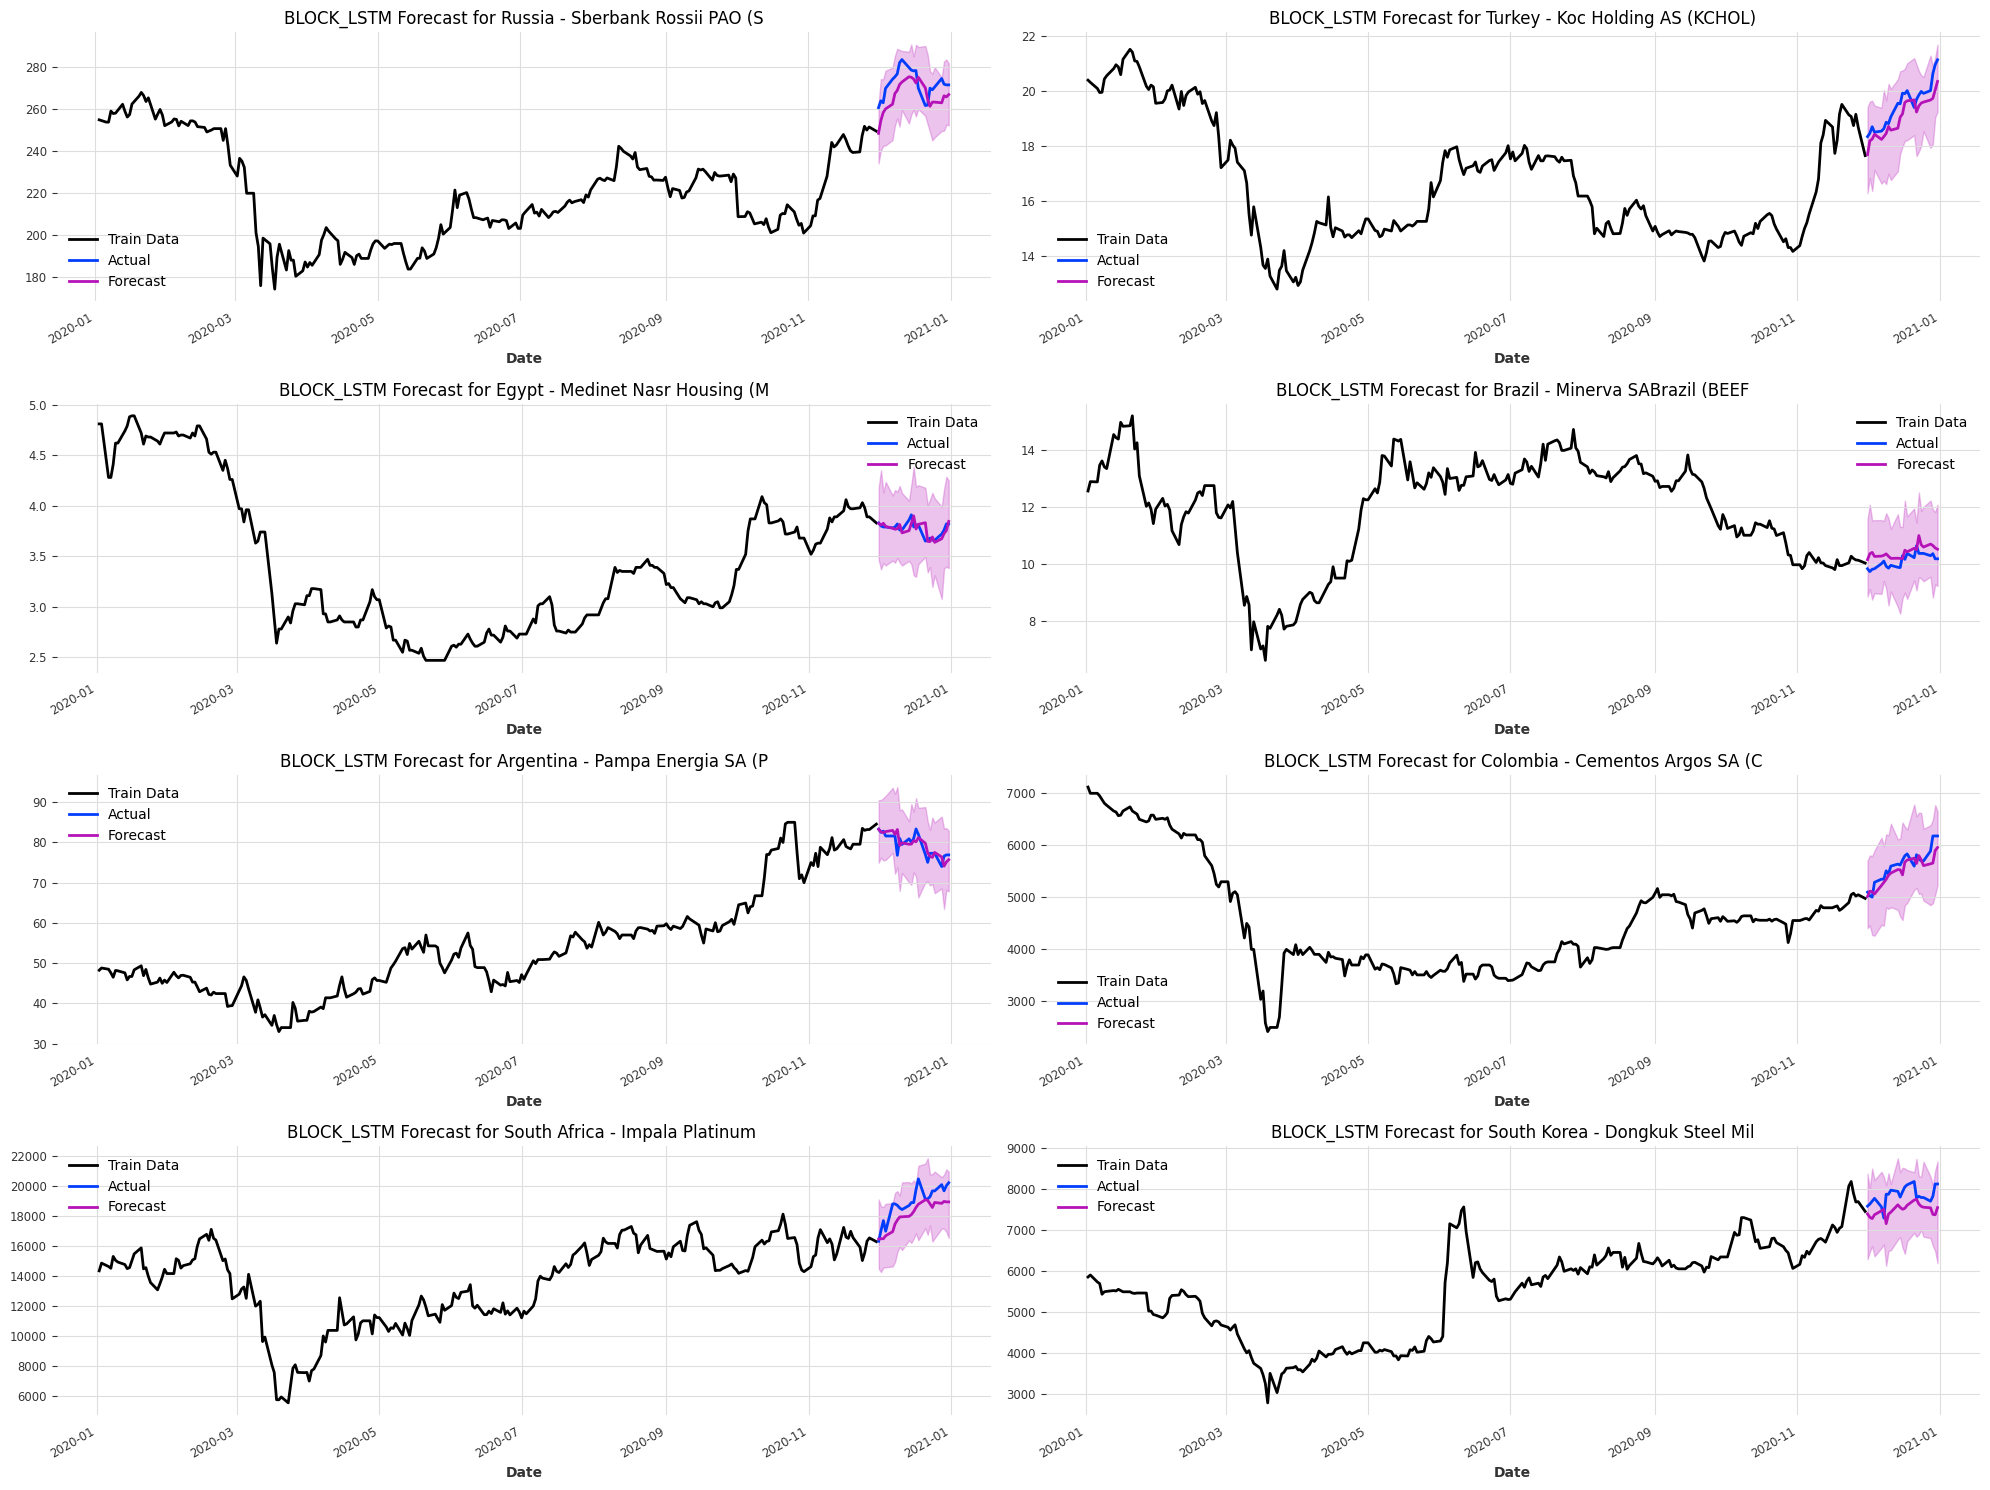

In [200]:
exchange_rates_df= pd.read_csv('/content/gdrive/My Drive/usd_to_cur_2020.csv', index_col='Date', parse_dates=True)
forecast_results_block_lstm, performance_metrics_block_lstm, model_block_lstm = ts_forecast_darts_BLOCK_LSTM(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020)

In [195]:
performance_metrics_block_lstm

MAE        RMSE      MAPE     SMAPE  \
Russia - Sberbank Rossii PAO (S    7.318825     7.84672  2.690226  2.725974   
Turkey - Koc Holding AS (KCHOL)    0.464452    0.521746   2.35957  2.393811   
Egypt - Medinet Nasr Housing (M    0.043979    0.060498  1.167609  1.164544   
Brazil - Minerva SABrazil (BEEF    0.335371    0.365659  3.335337  3.271457   
Argentina - Pampa Energia SA (P    1.447972    2.005611    1.8513  1.838433   
Colombia - Cementos Argos SA (C   151.22314  185.388595  2.639717  2.684013   
South Africa - Impala Platinum   835.938573  961.488882  4.370234  4.498831   
South Korea - Dongkuk Steel Mil    368.0455  412.186866  4.660422  4.796011   

                                     MASE  R2 Score  
Russia - Sberbank Rossii PAO (S  2.226259 -0.458504  
Turkey - Koc Holding AS (KCHOL)   1.55958  0.561783  
Egypt - Medinet Nasr Housing (M  0.754206   0.20722  
Brazil - Minerva SABrazil (BEEF  1.154603 -1.288152  
Argentina - Pampa Energia SA (P  1.011702  0.471858  
Colombia - Cementos Argos SA (C  1.607458  0.679267  
South Africa - Impala Platinum   1.730434  0.158081  
South Korea - Dongkuk Steel Mil  2.736097 -3.037885

### **2.3 Using the DARTS toolbox to implement the Transformer model which can also use past covariates**

In [196]:
from darts.metrics import mae, rmse, mape, smape, mase, r2_score
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.transformer_model import TransformerModel
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import logging
from darts import concatenate
from darts.utils.likelihood_models import GaussianLikelihood, LaplaceLikelihood

logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

def ts_forecast_darts_Transformer(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020):

  # Determine the business days in the validation data
  val_start_date = pd.Timestamp(f'{val_year}-{val_month}-01')
  val_end_date = pd.Timestamp(f'{val_year}-{val_month}-01')+ pd.DateOffset(months=1) - pd.DateOffset(days=1)
  val_index = pd.date_range(start=val_start_date, end=val_end_date, freq='B')
  val_steps = len(val_index)

  # Check if past_covariates
  if past_covariates_df is not None:
      past_covariates_df.sort_index(ascending=True, inplace=True)

  # Initialize empty lists for series
  target_series = []
  exog_series= []
  train_series= []
  test_series= []
  train_exog= []
  test_exog= []
  train_sub_series= []
  val_series= []
  val_exog= []
  train_sub_exog= []

 # Initalize results
  forecast_results = {}
  models = {}
  performance_metrics = pd.DataFrame(index=sheet_dict.keys(), columns=['MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R2 Score'])
  for company, df_comp in sheet_dict.items():
      # Sort the DataFrame
      df_comp.sort_index(ascending=True, inplace=True)

      # Append target and exogenous DataFrame
      tseries= TimeSeries.from_series(df_comp[[target_col]])
      train_series_comp, test_series_comp = tseries.split_before(test_start_date)
      train_sub_series_comp, val_series_comp = train_series_comp.split_before(val_start_date)
      target_series.append(tseries)
      train_series.append(train_series_comp)
      test_series.append(test_series_comp)
      train_sub_series.append(train_sub_series_comp)
      val_series.append(val_series_comp)

      exog_cols = [col for col in df_comp.columns if col != target_col]
      if exog_cols:
          if past_covariates_df is None:
              eseries = TimeSeries.from_dataframe(df_comp[exog_cols])
          else:
              past_covariates= TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries = concatenate([past_covariates, TimeSeries.from_dataframe(df_comp[exog_cols])], axis=1)
      else:
          if past_covariates_df is not None:
              past_covariates = TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              eseries= past_covariates

      exog_series.append(eseries)
      train_exog_comp, test_exog_comp = eseries.split_before(test_start_date)
      train_sub_exog_comp, val_exog_comp = train_exog_comp.split_before(val_start_date)
      train_exog.append(train_exog_comp)
      test_exog.append(test_exog_comp)
      train_sub_exog.append(train_sub_exog_comp)
      val_exog.append(val_exog_comp)


  # Scale the data
  scaler_target = Scaler()
  scaler_exog = Scaler()
  train_sub_series_scaled = scaler_target.fit_transform(train_sub_series)
  train_series_scaled = scaler_target.transform(train_series)
  test_series_scaled = scaler_target.transform(test_series)
  train_sub_exog_scaled = scaler_exog.fit_transform(train_sub_exog)
  train_exog_scaled = scaler_exog.transform(train_exog)
  test_exog_scaled = scaler_exog.transform(test_exog)
  val_series_scaled = scaler_target.transform(val_series)
  val_exog_scaled = scaler_exog.transform(val_exog)

  # Define and train the Transformer model
  model = TransformerModel(input_chunk_length=100,
                    output_chunk_length=1, random_state=0,
                      likelihood=LaplaceLikelihood(prior_b=0.1))

  model.fit(list(train_sub_series_scaled),
          past_covariates=list(train_sub_exog_scaled),
      epochs=100, verbose=True)

  pred_series = model.predict(n=val_steps,  num_samples=100,
                              series= train_sub_series_scaled,
                              past_covariates= train_exog_scaled)

  # Model
  models['model'] = model
  models['scale_target'] = scaler_target
  models['scale_exog'] =  scaler_exog

  # Unscaled forecast
  pred_series_unscaled = scaler_target.inverse_transform(pred_series)

  # Plotting and saving the forecast results
  plt.figure(figsize=(20, 15))
  for i, company in enumerate(sheet_dict.keys()):
    forecasts_df = pd.DataFrame(index=val_index, columns=['Forecast', 'Upper bound (75%ile)', 'Lower bound (25%ile)'])
    forecasts_df['Forecast'] = pred_series_unscaled[i].median().pd_series()
    forecasts_df['Upper bound (75%ile)'] = pred_series_unscaled[i].quantile(0.75).pd_series()
    forecasts_df['Lower bound (25%ile)'] = pred_series_unscaled[i].quantile(0.25).pd_series()
    forecast_results[company] = forecasts_df
    plt.subplot((len(sheet_dict.keys()) + 1) // 2, 2, i + 1)
    train_sub_series[i].plot(label="Train Data")
    val_series[i].plot(label="Actual")
    pred_series_unscaled[i].plot(label="Forecast")
    plt.title(f'Transformer Forecast for {company}')
    plt.legend()
  plt.tight_layout()
  plt.show()

  # Evaluate the performance of the model

  for i, company in enumerate(sheet_dict.keys()):
      performance_metrics.loc[company, 'MAE'] = mae(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'RMSE'] = rmse(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MAPE'] = mape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'SMAPE'] = smape(val_series[i], pred_series_unscaled[i])
      performance_metrics.loc[company, 'MASE'] = mase(val_series[i], pred_series_unscaled[i], train_series[i])
      performance_metrics.loc[company, 'R2 Score'] = r2_score(val_series[i], pred_series_unscaled[i])

  return forecast_results, performance_metrics, models

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 960    | train
6 | positional_encoding | _PositionalEncoding | 0      |

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

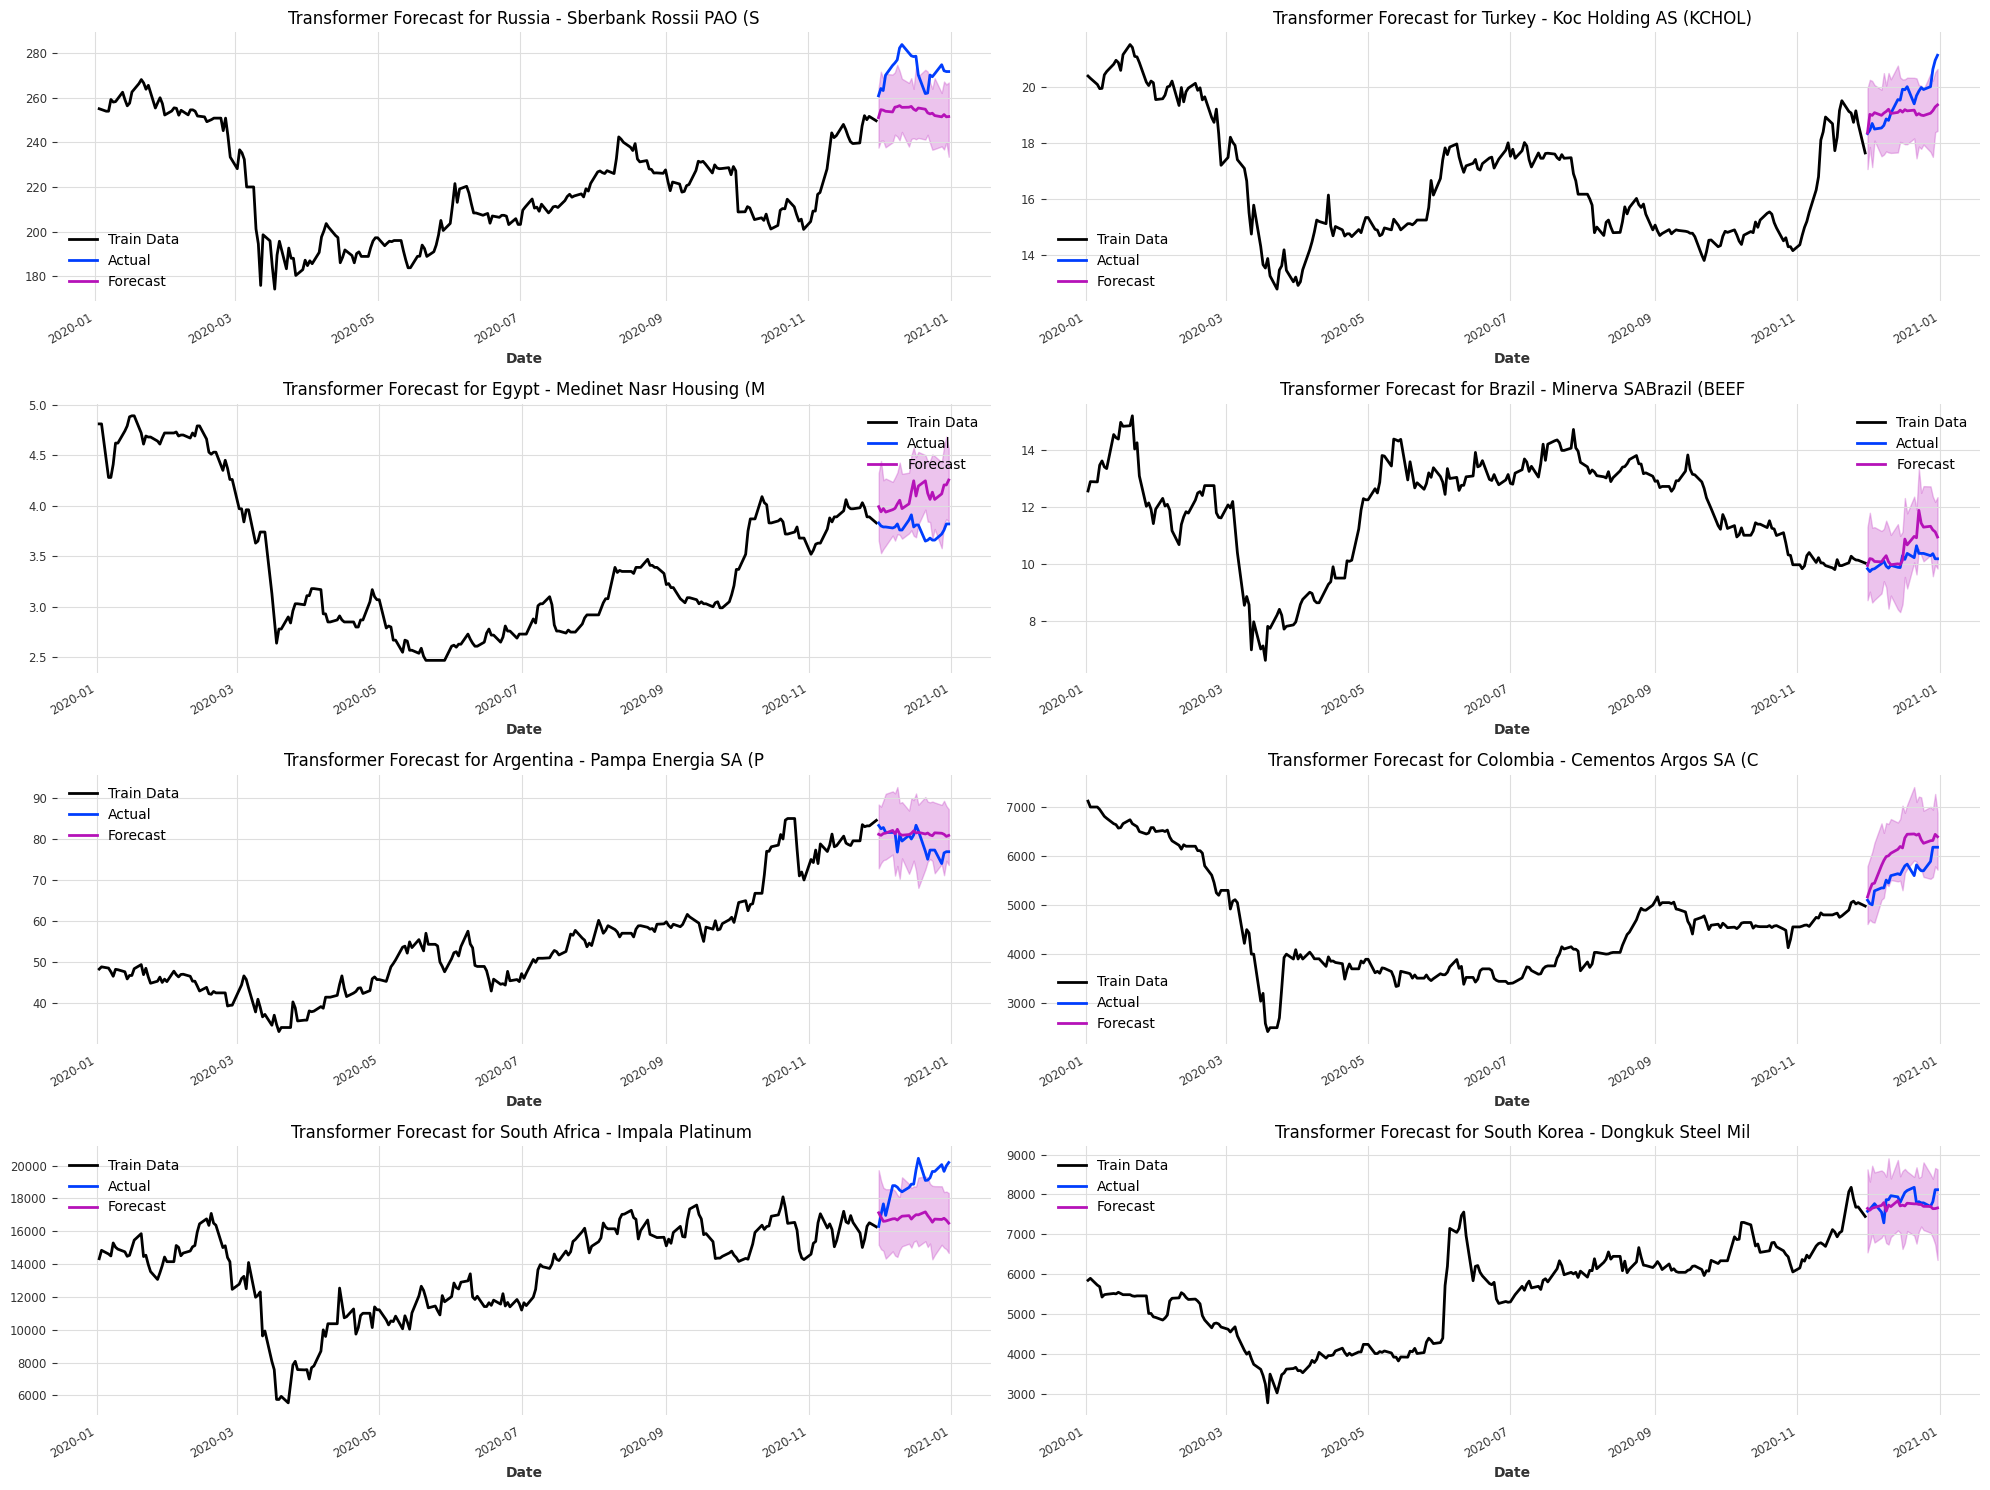

In [197]:
exchange_rates_df= pd.read_csv('/content/gdrive/My Drive/usd_to_cur_2020.csv', index_col='Date', parse_dates=True)
forecast_results_transformer, performance_metrics_transformer, model_transformer = ts_forecast_darts_Transformer(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, val_month='December', val_year=2020)

In [198]:
performance_metrics_transformer

MAE         RMSE       MAPE  \
Russia - Sberbank Rossii PAO (S    18.294635    19.222353   6.674787   
Turkey - Koc Holding AS (KCHOL)     0.682127     0.822468   3.426445   
Egypt - Medinet Nasr Housing (M     0.313055     0.339705   8.344988   
Brazil - Minerva SABrazil (BEEF     0.499301      0.64172   4.889146   
Argentina - Pampa Energia SA (P     2.607112     3.343953   3.369485   
Colombia - Cementos Argos SA (C   457.836455    495.39944   8.152046   
South Africa - Impala Platinum   2145.724602  2343.096746  11.122554   
South Korea - Dongkuk Steel Mil   189.871004   246.375712   2.407033   

                                     SMAPE      MASE   R2 Score  
Russia - Sberbank Rossii PAO (S   6.928021  5.564908  -7.752747  
Turkey - Koc Holding AS (KCHOL)   3.494055  2.290507   -0.08895  
Egypt - Medinet Nasr Housing (M   7.953144  5.368592 -23.996419  
Brazil - Minerva SABrazil (BEEF   4.704029  1.718976  -6.047291  
Argentina - Pampa Energia SA (P   3.284982  1.821596  -0.468173  
Colombia - Cementos Argos SA (C   7.782542  4.866668   -1.29028  
South Africa - Impala Platinum   11.886181  4.441757  -3.999909  
South Korea - Dongkuk Steel Mil   2.433531  1.411525  -0.442651

In [207]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])
        y.append(data[i + seq_length, 0])  # Adjust to use the first column, assuming single feature
    return np.array(X), np.array(y)

def generate_bollinger_bands(df, window=20, num_std=2):
    """
    Generate Bollinger Bands.
    :param df: DataFrame with actual prices.
    :param window: Window size for moving average.
    :param num_std: Number of standard deviations for the bands.
    :return: DataFrame with Bollinger Bands.
    """
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band

def generate_signals(df, lower_band, upper_band):
    """
    Generate buy/sell signals based on Bollinger Bands.
    :param df: DataFrame with actual prices.
    :param lower_band: DataFrame with the lower Bollinger Band.
    :param upper_band: DataFrame with the upper Bollinger Band.
    :return: DataFrame with signals.
    """
    signals = pd.DataFrame(index=df.index)
    signals['Price'] = df
    signals['Lower Band'] = lower_band
    signals['Upper Band'] = upper_band
    signals['Signal'] = 0  # Default to hold

    # Generate buy/sell signals
    signals['Signal'] = np.where(signals['Price'] < signals['Lower Band'], 1,  # Buy signal
                                 np.where(signals['Price'] > signals['Upper Band'], -1, 0))  # Sell signal

    return signals

def prediction_strategy(signals, initial_balance=1000):
    """
    Backtest a trading strategy based on generated signals.
    :param signals: DataFrame with buy/sell signals.
    :param initial_balance: Starting balance for the strategy.
    :return: Final balance and DataFrame with portfolio values over time.
    """
    balance = initial_balance
    shares = 0
    portfolio = []
    buy_sell = []

    for i in range(len(signals)):
        if signals['Signal'].iloc[i] == 1:  # Buy
            if balance > 0:
                shares = balance / signals['Price'].iloc[i]
                balance = 0
                buy_sell.append(('Buy', signals.index[i], signals['Price'].iloc[i]))
        elif signals['Signal'].iloc[i] == -1:  # Sell
            if shares > 0:
                balance = shares * signals['Price'].iloc[i]
                shares = 0
                buy_sell.append(('Sell', signals.index[i], signals['Price'].iloc[i]))
        portfolio.append(balance + shares * signals['Price'].iloc[i])

    portfolio_df = pd.DataFrame(portfolio, index=signals.index, columns=['Portfolio Value'])
    return balance + shares * signals['Price'].iloc[-1], portfolio_df, buy_sell

In [208]:
 # Initialize a DataFrame to store the forecasts

 def prediction_strategy_model(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, test_start='2021-01-01', test_end = '2021-03-31'):

  test_start_date = pd.Timestamp(f'{test_start}-01')
  test_end_date = pd.Timestamp(f'{test_end}-01')
  test_index = pd.date_range(start=test_start, end=test_end, freq='B')
  test_steps = len(test_index)

  # Check if past_covariates
  if past_covariates_df is not None:
      past_covariates_df.sort_index(ascending=True, inplace=True)

  # Initialize empty lists for series
  target_series_all = []
  exog_series_all= []
  train_series_all= []
  test_series_all= []
  train_exog_all= []
  test_exog_all= []
  forecast_df = pd.DataFrame(index= test_index)

  for company, df_comp in sheet_dict.items():
      # Sort the DataFrame
      df_comp.sort_index(ascending=True, inplace=True)

      # Append target and exogenous DataFrame
      target_series= TimeSeries.from_series(df_comp[[target_col]])
      train_series, test_series = target_series.split_before(test_start_date)
      target_series_all.append(target_series)
      train_series_all.append(train_series)
      test_series_all.append(test_series)

      exog_cols = [col for col in df_comp.columns if col != target_col]
      if exog_cols:
          if past_covariates_df is None:
              exog_series = TimeSeries.from_dataframe(df_comp[exog_cols])
          else:
              past_covariates= TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              exog_series = concatenate([past_covariates, TimeSeries.from_dataframe(df_comp[exog_cols])], axis=1)
      else:
          if past_covariates_df is not None:
              past_covariates = TimeSeries.from_dataframe(past_covariates_df.copy().reindex(df_comp.index).dropna())
              exog_series= past_covariates

      exog_series_all.append(exog_series)
      train_exog, test_exog = exog_series.split_before(test_start_date)
      train_exog_all.append(train_exog)
      test_exog_all.append(test_exog)



  # Scale the data
  scaler_target = Scaler()
  scaler_exog = Scaler()

  train_series_scaled = scaler_target.fit_transform(train_series_all)
  test_series_scaled = scaler_target.transform(test_series_all)
  train_exog_scaled = scaler_exog.fit_transform(train_exog_all)
  test_exog_scaled = scaler_exog.transform(test_exog_all)
  exog_series_scaled = scaler_exog.transform(exog_series_all)

  # Define and train the Transformer model
  model = BlockRNNModel(input_chunk_length=100,
                    output_chunk_length=1, random_state=0, model='LSTM')

  model.fit(train_series_scaled,
          past_covariates=train_exog_scaled,epochs=100, verbose=True)

  pred_series = model.predict(n= test_steps, series= train_series_scaled,
                              past_covariates= exog_series_scaled)

  # Unscaled forecast
  pred_series_unscaled = scaler_target.inverse_transform(pred_series)
  for i, (company, df) in enumerate(sheet_dict.items()):
      forecast_df[company] = pred_series_unscaled[i].pd_series()

      # Generate Bollinger Bands
      rolling_mean, upper_band, lower_band = generate_bollinger_bands(df[target_col])

      # Generate signals and backtest
      signals = generate_signals(df[target_col], lower_band, upper_band)
      final_balance, portfolio_df, buy_sell = prediction_strategy(signals)

      # Plot the actual vs forecasted values with Bollinger Bands and buy/sell signals
      plt.figure(figsize=(14, 8))
      plt.plot(df.index, df[target_col], label='Actual')
      plt.plot(forecast_df.index, forecast_df[company], label='Forecast', linestyle='--')
      plt.fill_between(signals.index, signals['Upper Band'], signals['Lower Band'], color='grey', alpha=0.3, label='Bollinger Bands')
      plt.scatter([date for signal, date, price in buy_sell if signal == 'Buy'],
                  [price for signal, date, price in buy_sell if signal == 'Buy'],
                  marker='^', color='g', label='Buy Signal', alpha=1)

      plt.scatter([date for signal, date, price in buy_sell if signal == 'Sell'],
                  [price for signal, date, price in buy_sell if signal == 'Sell'],
                  marker='v', color='r', label='Sell Signal', alpha=1)
      plt.legend(loc='best')
      plt.title(f'Rolling Forecast vs Actual with Bollinger Bands for {company}')
      plt.show()

      # Plot the portfolio value over time
      plt.figure(figsize=(14, 8))
      plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value')
      plt.title('Portfolio Value Over Time')
      plt.xlabel('Date')
      plt.ylabel('Portfolio Value')
      plt.legend(loc='best')
      plt.show()



INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.1 K  | train
6 | fc              | Sequential       | 26     | train
-------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

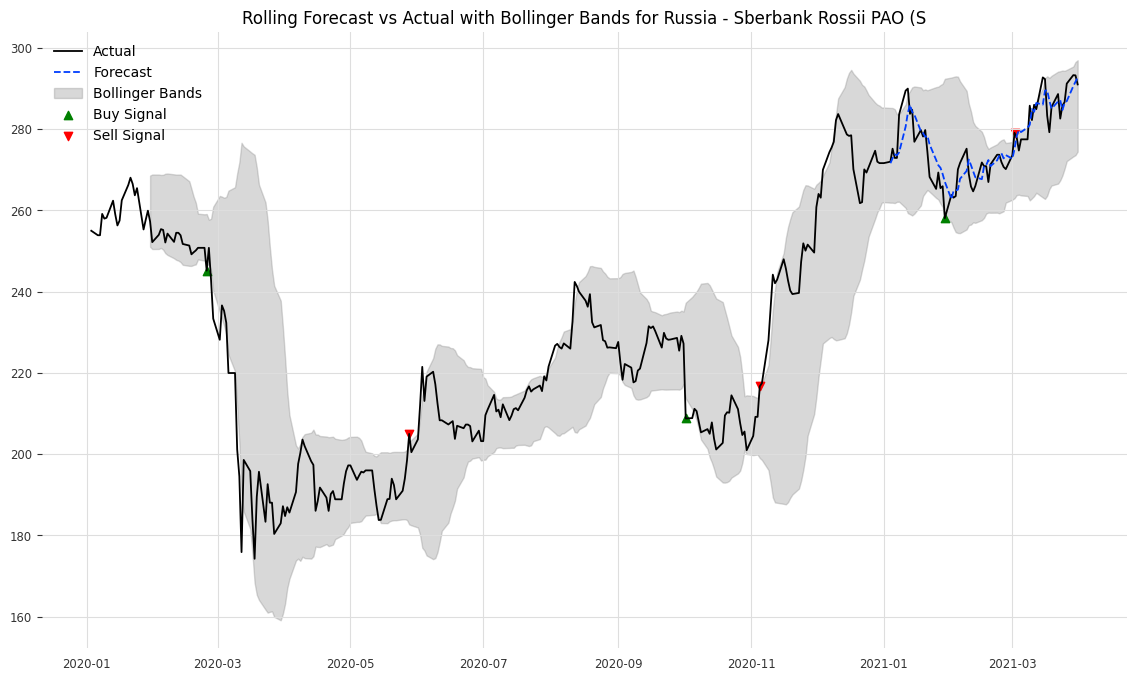

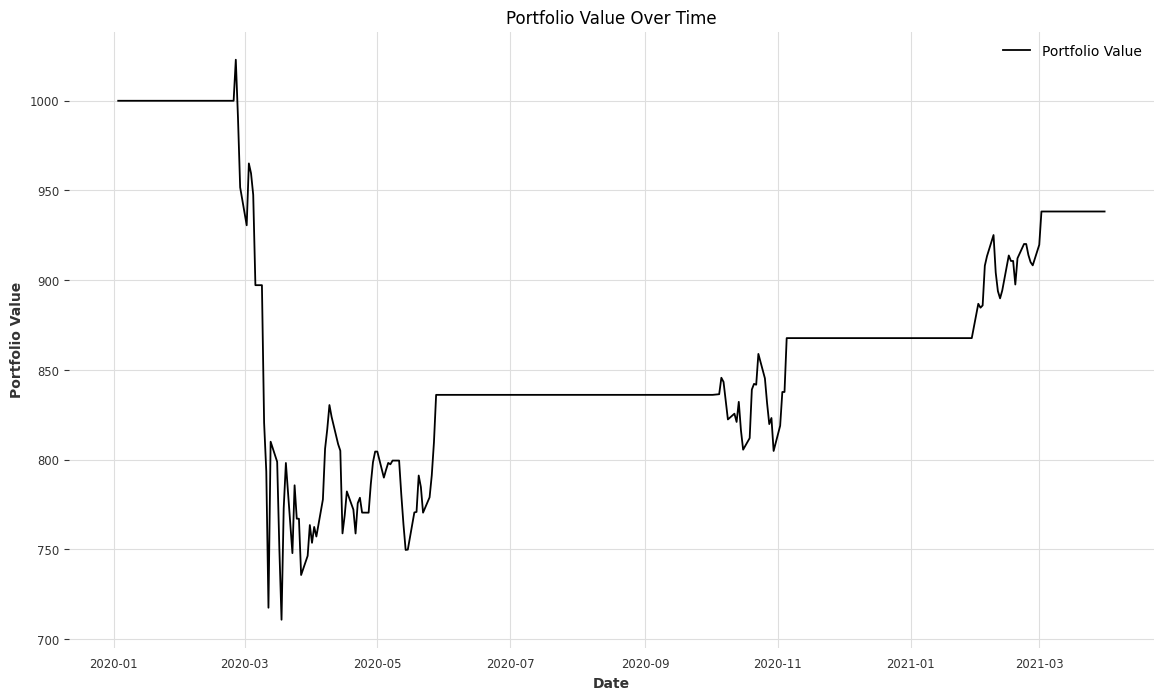

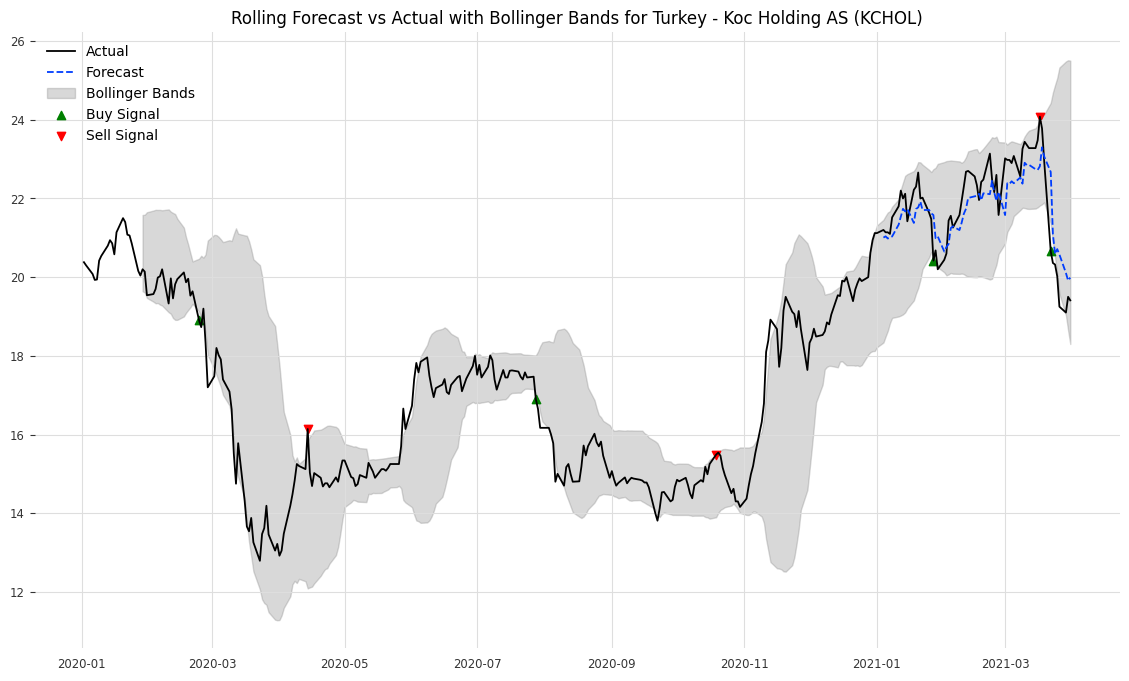

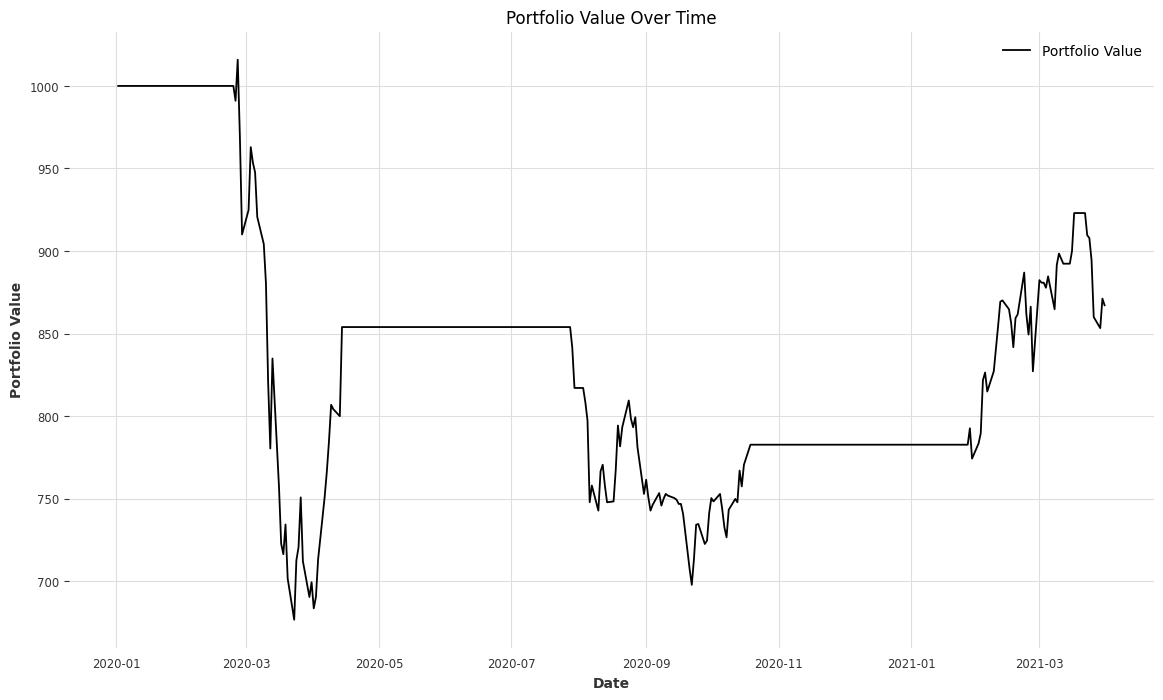

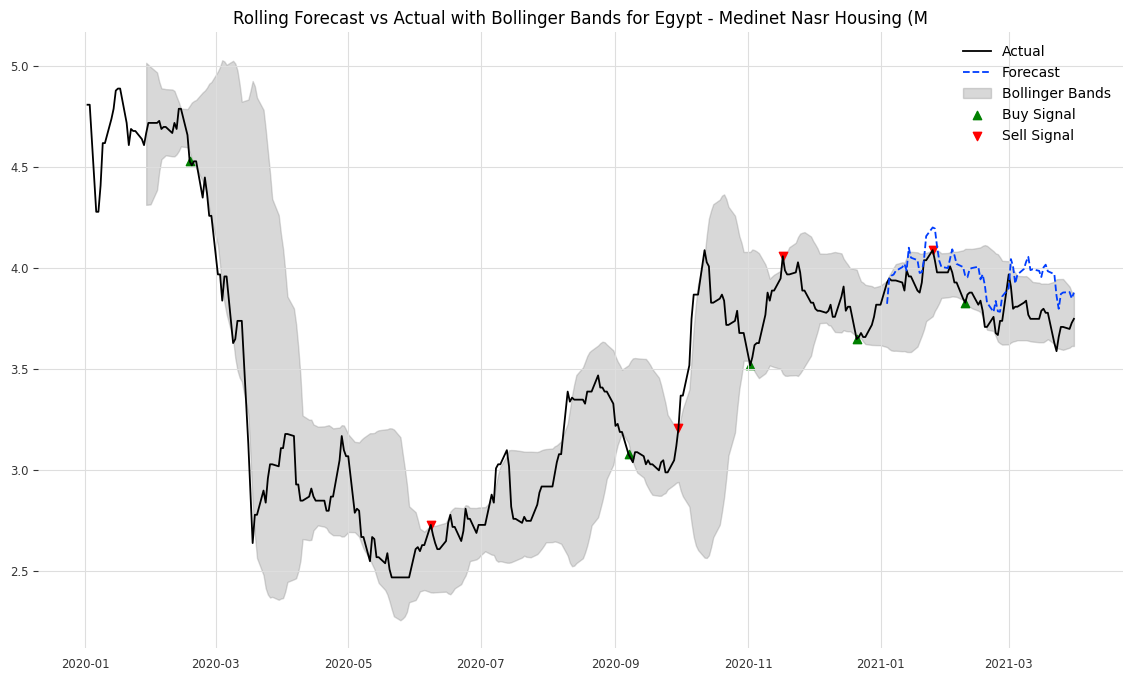

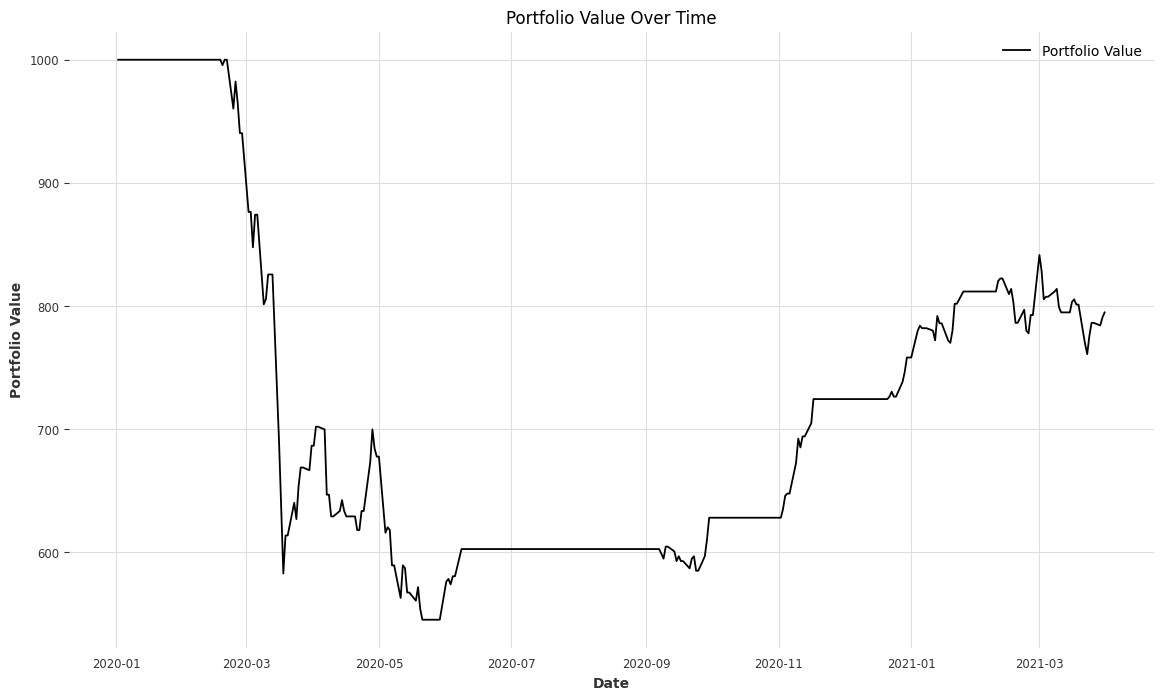

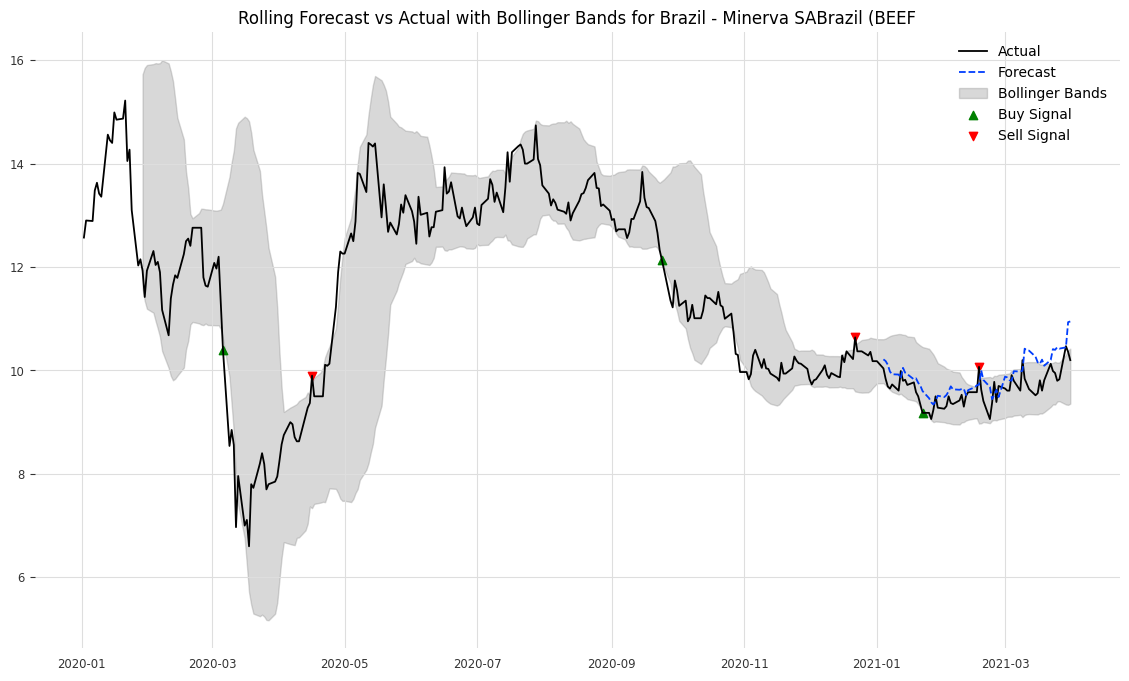

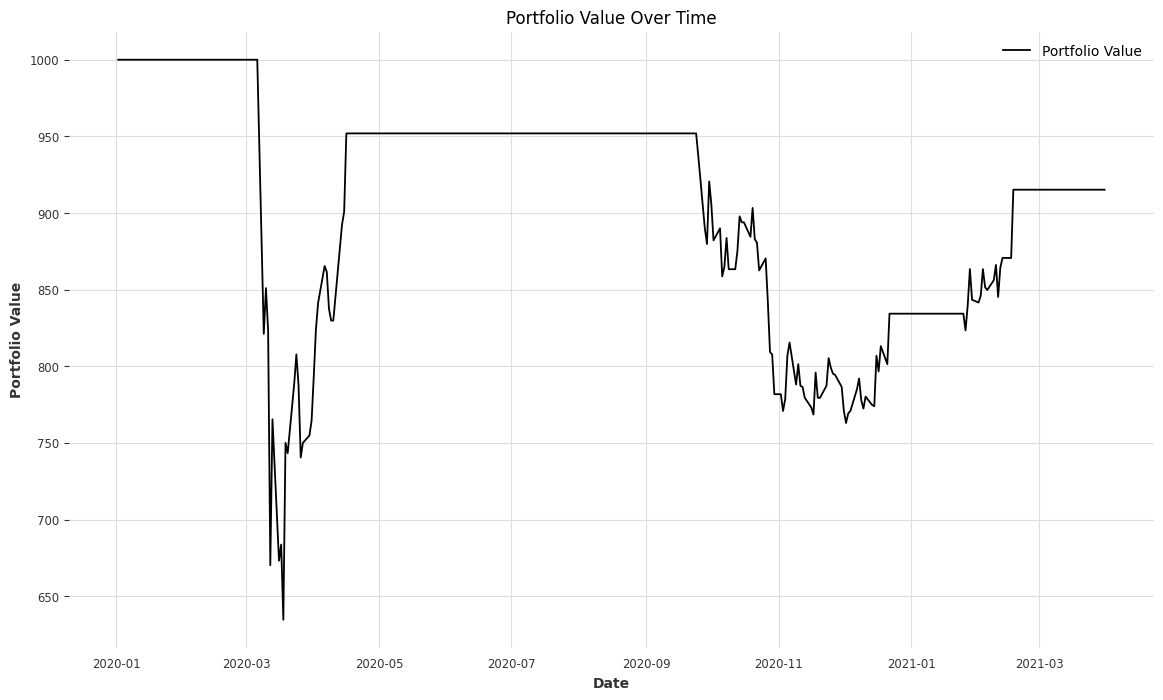

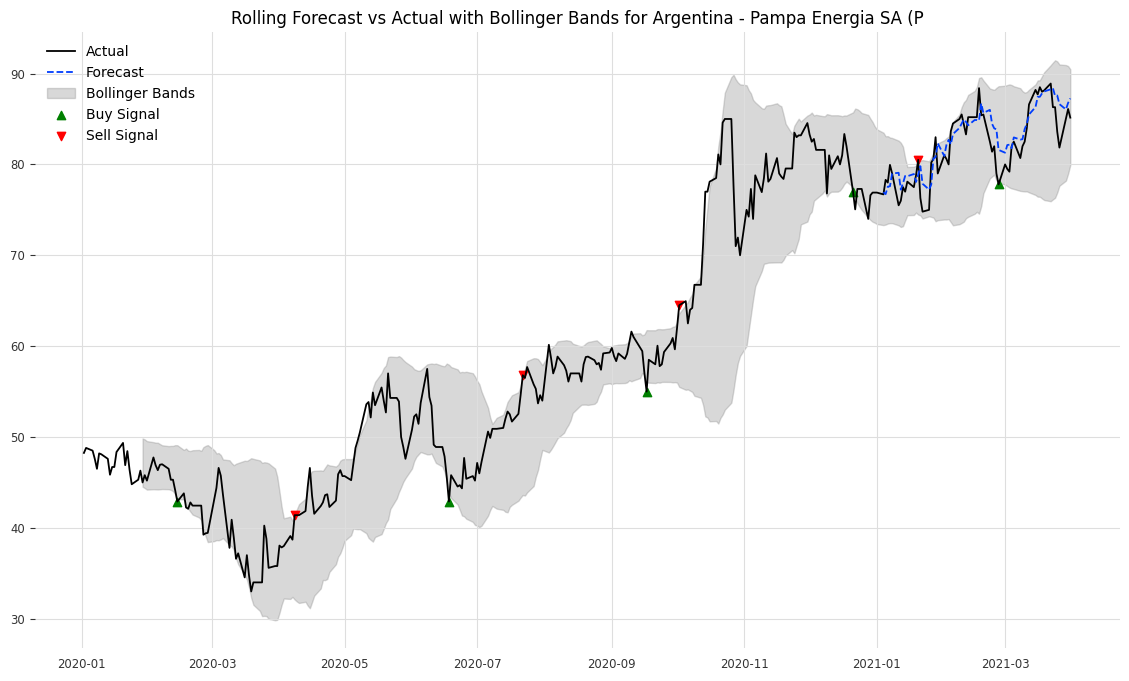

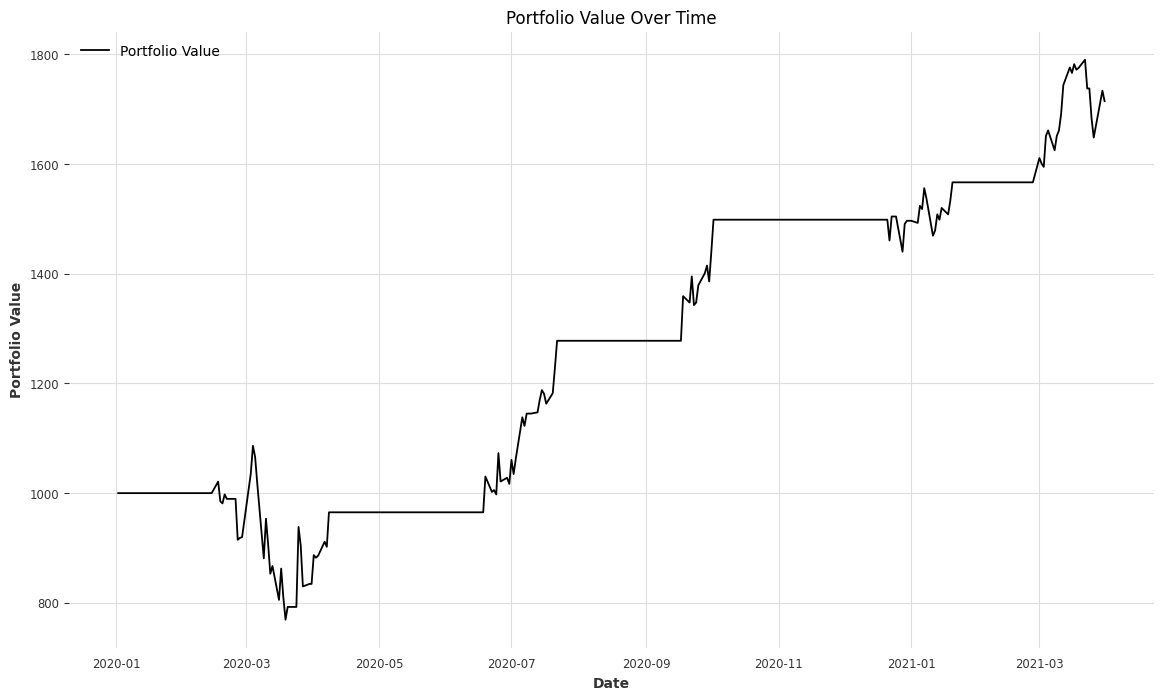

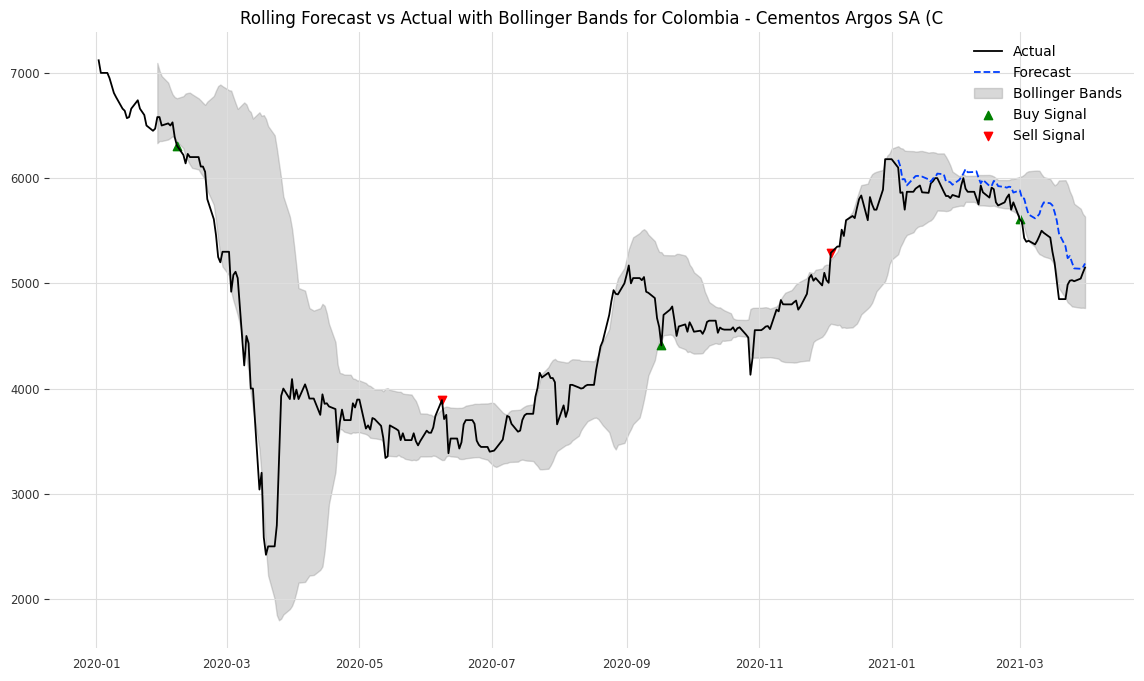

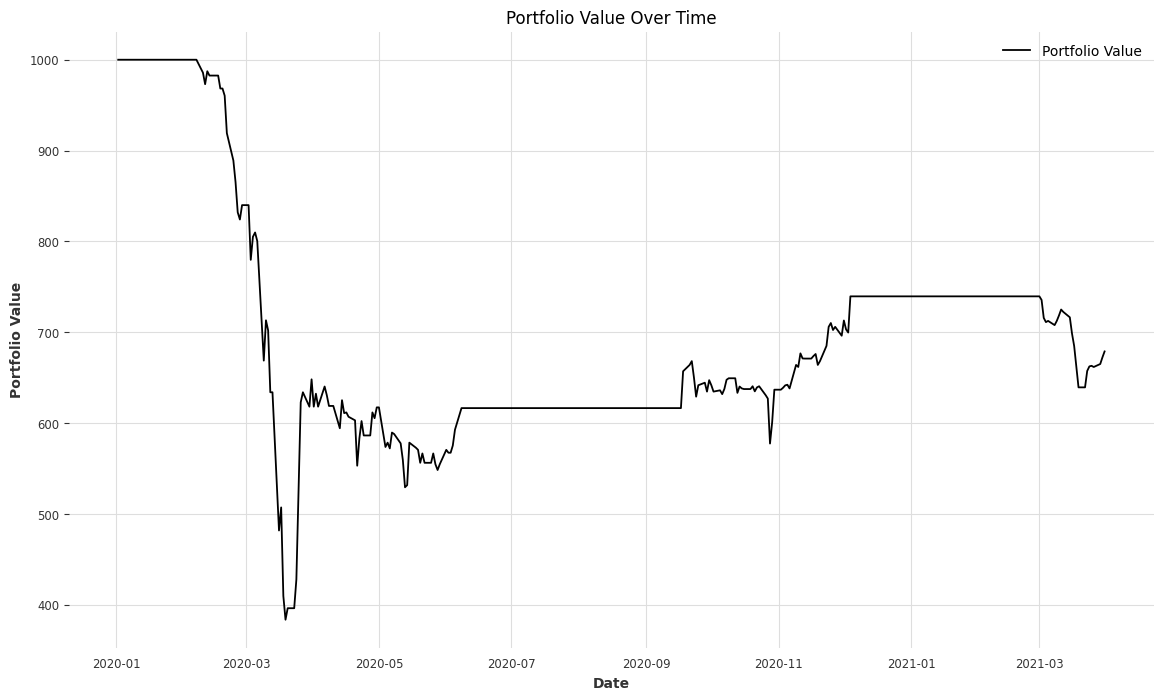

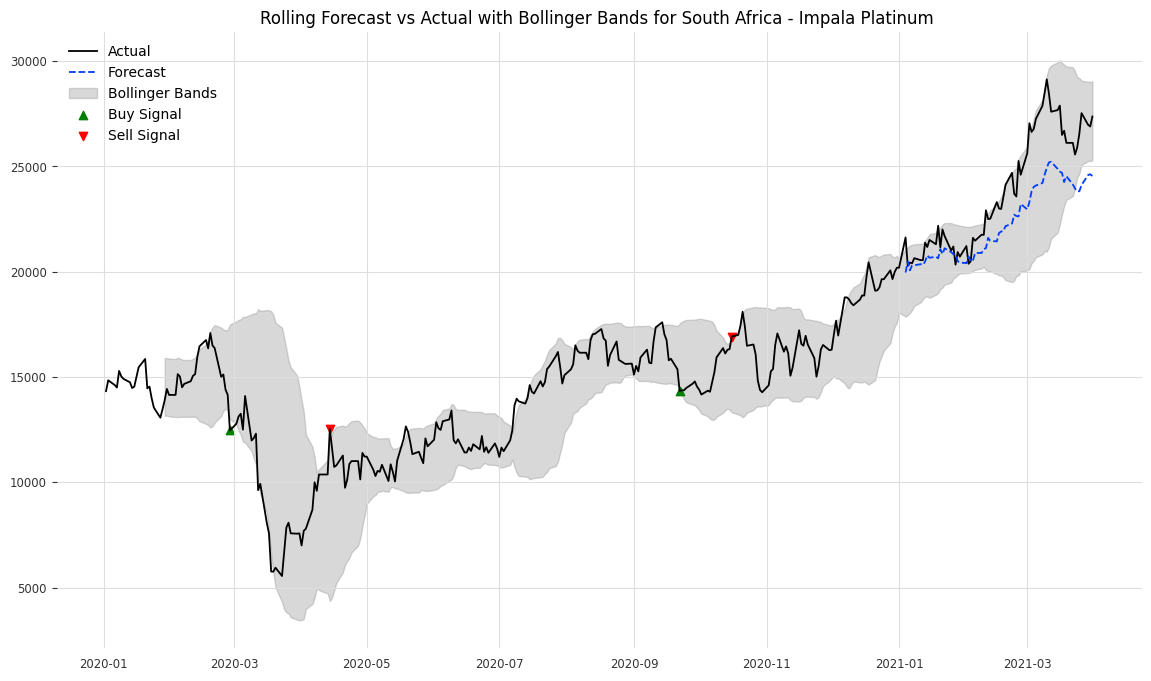

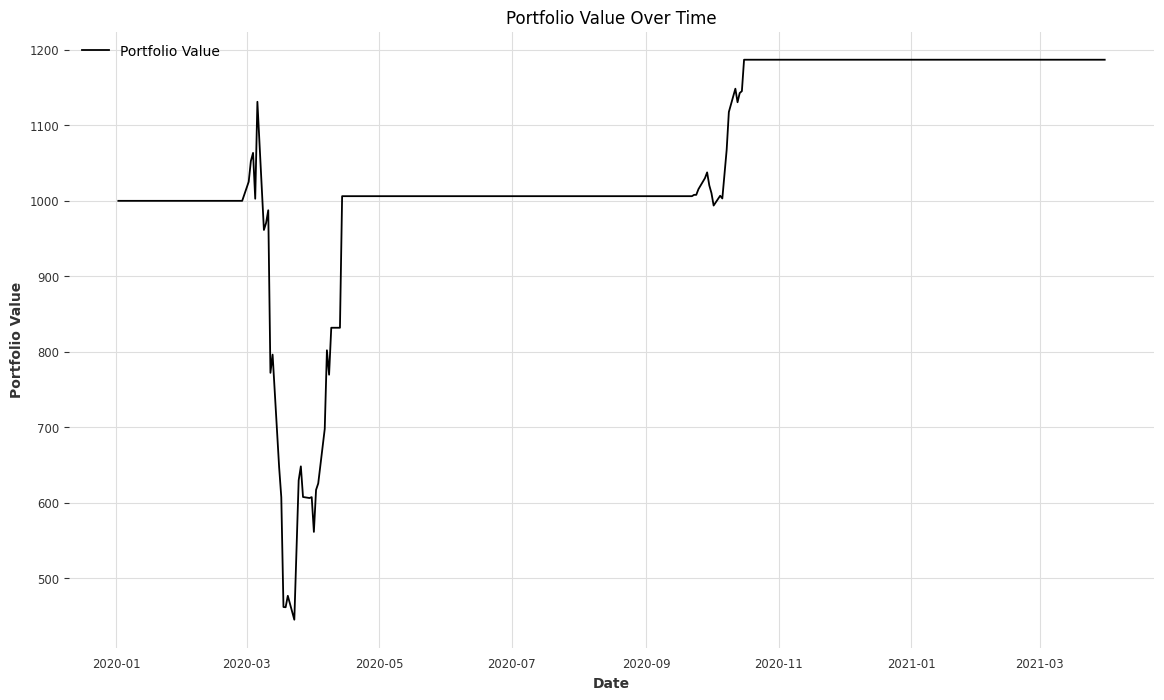

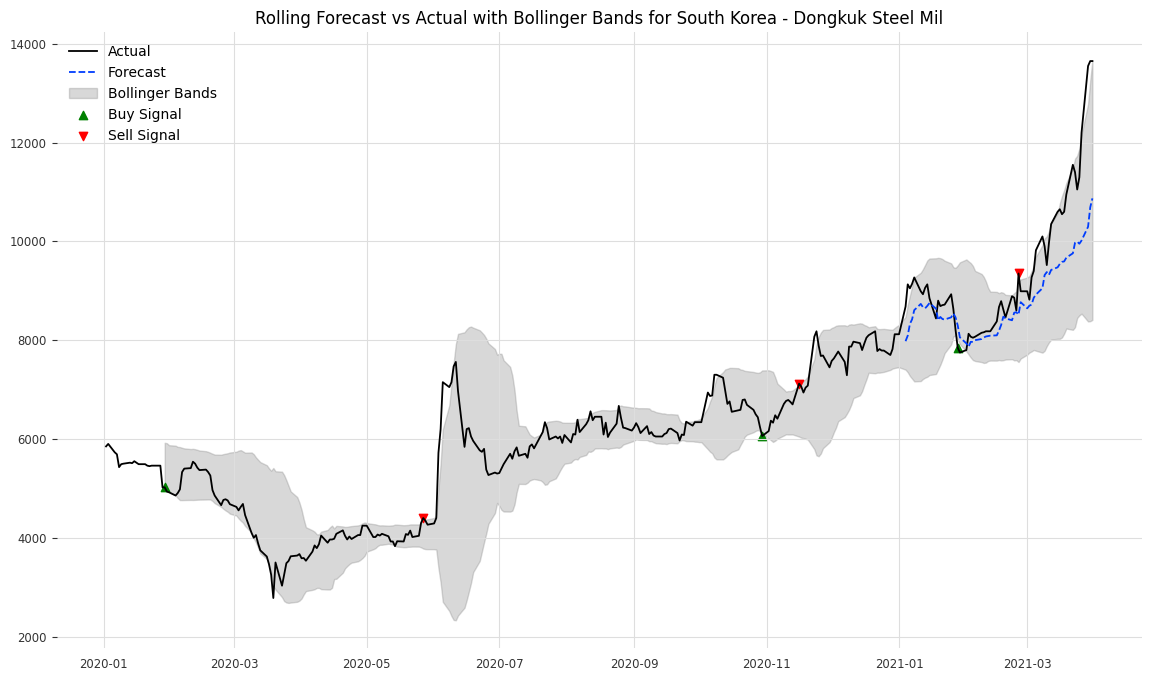

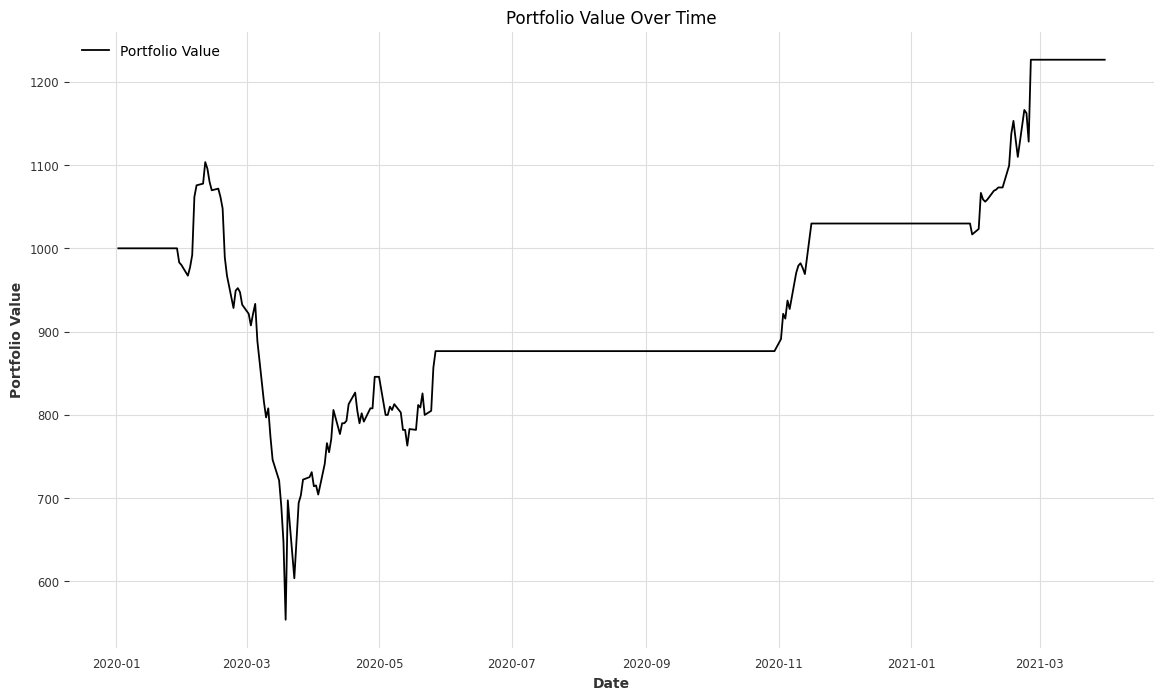

In [209]:
prediction_strategy_model(sheet_dict, target_col='Price', past_covariates_df = exchange_rates_df, test_start='2021-01-01', test_end = '2021-03-31')

In [ ]:
# Example usage with hypothetical data
dates = pd.date_range(start='2021-01-01', end = '2021-03-31', freq='B')
actual_prices = test_series[1].pd_series()
df_actual = test_series[1].pd_dataframe()
df_lower_bound = pred_series_unscaled[1].quantile(0.30).pd_dataframe()
df_median = pred_series_unscaled[1].median().pd_dataframe()
df_upper_bound = pred_series_unscaled[1].quantile(0.40).pd_dataframe()

# Generate signals and backtest
signals = generate_signals(df_actual, df_lower_bound, df_median, df_upper_bound)
final_balance, portfolio_df = prediction_strategy(signals)

# Plotting the portfolio value over time
plt.figure(figsize=(10, 6))
portfolio_df.plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
#actual_prices.plot(label='Actual Prices')
plt.show()

print(f"Final portfolio balance: ${final_balance:.2f}")

<Figure size 1000x600 with 0 Axes>

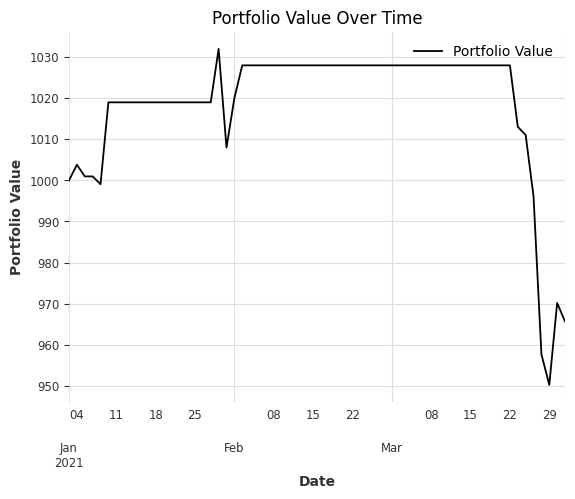

Final portfolio balance: $965.73


In [ ]:
def generate_signals(df, lower_bound, median, upper_bound):
    """
    Generate buy/sell signals based on forecasted prices.
    :param df: DataFrame with actual prices.
    :param lower_bound: DataFrame with the 25th percentile forecasted prices.
    :param median: DataFrame with the median forecasted prices.
    :param upper_bound: DataFrame with the 75th percentile forecasted prices.
    :return: DataFrame with signals.
    """
    signals = pd.DataFrame(index=df.index)
    signals['Price'] = df
    signals['25th Percentile'] = lower_bound
    signals['Median'] = median
    signals['75th Percentile'] = upper_bound
    signals['Signal'] = 0  # Default to hold

    # Generate buy/sell signals
    signals['Signal'] = np.where(signals['Price'] < signals['25th Percentile'], 1,  # Buy signal
                                 np.where(signals['Price'] > signals['75th Percentile'], -1, 0))  # Sell signal

    return signals
def generate_dynamic_signals(df, lower_bound, median, upper_bound, short_window=5, long_window=20):
    """
    Generate buy/sell signals based on dynamic thresholds using moving averages.
    :param df: DataFrame with actual prices.
    :param lower_bound: DataFrame with the 25th percentile forecasted prices.
    :param median: DataFrame with the median forecasted prices.
    :param upper_bound: DataFrame with the 75th percentile forecasted prices.
    :param short_window: Short window for moving average.
    :param long_window: Long window for moving average.
    :return: DataFrame with signals.
    """
    signals = pd.DataFrame(index=df.index)
    signals['Price'] = df
    signals['25th Percentile'] = lower_bound
    signals['Median'] = median
    signals['75th Percentile'] = upper_bound
    signals['Signal'] = 0  # Default to hold


    # Calculate moving averages
    signals['Short MA'] = signals['Price'].rolling(window=short_window, min_periods=1).mean()
    signals['Long MA'] = signals['Price'].rolling(window=long_window, min_periods=1).mean()

    # Minimize hold period by using moving averages
    signals['Signal'] = np.where(signals['Short MA'] > signals['Long MA'],
                                 np.where(signals['Signal'] == -1, 0, signals['Signal']), signals['Signal'])
    signals['Signal'] = np.where(signals['Short MA'] < signals['Long MA'],
                                 np.where(signals['Signal'] == 1, 0, signals['Signal']), signals['Signal'])
    return signals

def prediction_strategy(signals, initial_balance=1000):
    """
    Backtest a trading strategy based on generated signals.
    :param signals: DataFrame with buy/sell signals.
    :param initial_balance: Starting balance for the strategy.
    :return: Final balance and DataFrame with portfolio values over time.
    """
    balance = initial_balance
    shares = 0
    portfolio = []

    for i in range(len(signals)):
        if signals['Signal'].iloc[i] == 1:  # Buy
            if balance > 0:
                shares = balance / signals['Price'].iloc[i]
                balance = 0
        elif signals['Signal'].iloc[i] == -1:  # Sell
            if shares > 0:
                balance = shares * signals['Price'].iloc[i]
                shares = 0
        portfolio.append(balance + shares * signals['Price'].iloc[i])

    portfolio_df = pd.DataFrame(portfolio, index=signals.index, columns=['Portfolio Value'])
    return balance + shares * signals['Price'].iloc[-1], portfolio_df

# Example usage with hypothetical data
dates = pd.date_range(start='2021-01-01', end = '2021-03-31', freq='B')
actual_prices = test_series[1].pd_series()
df_actual = test_series[1].pd_dataframe()
df_lower_bound = pred_series_unscaled[1].quantile(0.30).pd_dataframe()
df_median = pred_series_unscaled[1].median().pd_dataframe()
df_upper_bound = pred_series_unscaled[1].quantile(0.40).pd_dataframe()

# Generate signals and backtest
signals = generate_signals(df_actual, df_lower_bound, df_median, df_upper_bound)
final_balance, portfolio_df = prediction_strategy(signals)

# Plotting the portfolio value over time
plt.figure(figsize=(10, 6))
portfolio_df.plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
#actual_prices.plot(label='Actual Prices')
plt.show()

print(f"Final portfolio balance: ${final_balance:.2f}")

In [ ]:
def generate_signals(df, forecast_df, threshold=0.02):
    """
    Generate buy/sell signals based on forecasted prices.
    :param df: DataFrame with actual prices.
    :param forecast_df: DataFrame with forecasted prices.
    :param threshold: Threshold for generating signals.
    :return: DataFrame with signals.
    """
    signals = pd.DataFrame(index=df.index)
    signals['Price'] = df['Price']
    signals['Forecast'] = forecast_df['Price']
    signals['Signal'] = 0  # Default to hold

    # Generate buy/sell signals
    signals['Signal'] = np.where(signals['Forecast'] > signals['Price'] * (1 + threshold), 1,  # Buy signal
                                 np.where(signals['Forecast'] < signals['Price'] * (1 - threshold), -1, 0))  # Sell signal
    return signals

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [ ]:
import pandas as pd
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def time_series_forecast_chronos(data, target_col='Price', forecast_month='December', forecast_year=2020, prediction_length=12, num_samples=20, device='cuda'):
    # Ensure the datetime index has a frequency
    if data.index.freq is None:
        data.index.freq = pd.infer_freq(data.index)
    if data.index.freq is None:  # If still None, set to business day frequency
        data.index.freq = 'B'

    # Determine the business days in the forecast month
    forecast_start_date = pd.to_datetime(f'{forecast_year}-{forecast_month}-01')
    forecast_end_date = forecast_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
    forecast_steps = len(forecast_index)

    # Split data into training and validation sets
    train_data = data.loc[data.index < forecast_start_date]
    val_data = data.loc[(data.index >= forecast_start_date) & (data.index <= forecast_end_date)]

    # Debug prints
    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")

    # Check if train_data or val_data is empty
    if train_data.empty or val_data.empty:
        print("Training or validation data is empty. Check the date range and data alignment.")
        return

    # Initialize ChronosPipeline
    pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-small",
        device_map= "cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
        torch_dtype=torch.bfloat16,
    )

    # Initialize a DataFrame to store the forecasts
    forecast_df = pd.DataFrame(index=forecast_index, columns=['Forecast'])

    # Perform rolling forecast
    last_sequence = train_data[target_col].values

    for i in range(forecast_steps):
        context_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
        forecast = pipeline.predict(
            context=context_tensor,
            prediction_length=1,
            num_samples=num_samples,
        )
        y_pred = forecast[0, 0, 0].item()

        # Append the forecasted value to the forecast DataFrame
        forecast_df.iloc[i] = y_pred

        # Update the last sequence with the predicted value
        last_sequence = np.append(last_sequence[1:], y_pred)

    # Evaluate the model
    mse_chronos = mean_squared_error(val_data[target_col], forecast_df['Forecast'])
    print(f'Mean Squared Error for Chronos T5: {mse_chronos}')

    # Plot the actual vs forecasted values with confidence intervals
    plt.figure(figsize=(12, 6))
    combined_data = pd.concat([train_data[target_col], val_data[target_col]])
    plt.plot(combined_data.index, combined_data, label='Actual')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
    plt.legend(loc='best')
    plt.title('Rolling Forecast vs Actual')
    plt.show()

Training data shape: (235, 21)
Validation data shape: (23, 21)


c:\Users\prady\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Mean Squared Error for Chronos T5: 0.7162539667403174


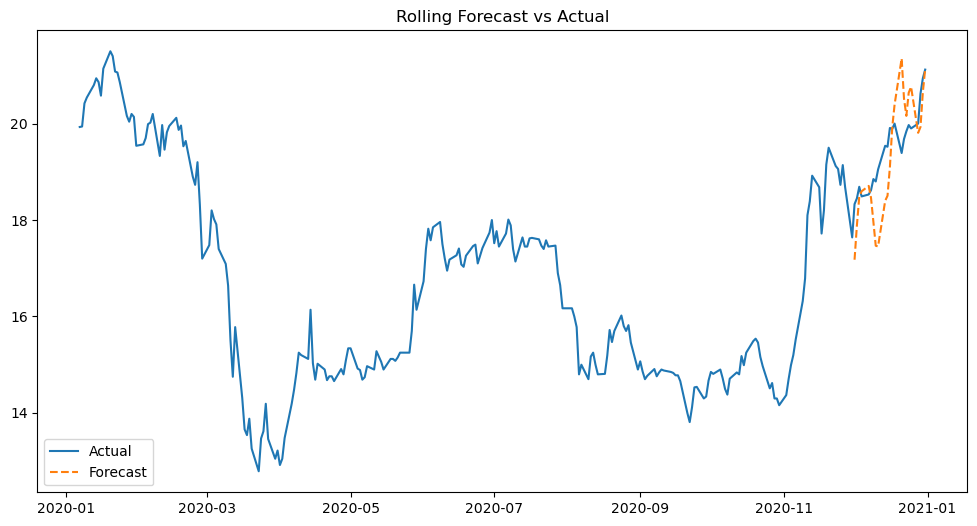

In [ ]:
time_series_forecast_chronos(train_data)